## Results
Here are the results of the model tuning.  Base model refers to create_cnn_model run with default arguments.  Please scroll below to see code and more detailed performance of each model.
| Model | Accuracy    | Notes | Next Steps |
|----------|------------------|-------------|----------|  
| 1        | 35%        | Base model, 10 epochs, Batch size = 32 | Doesn't seem to have converged--> increase epochs |  
| 2        | 37% | Base model, 20 epochs, Batch size = 32 | Increase batch size to see stabilize model |
| 3        | 38%        | Base model, 20 epochs, Batch size = 64 |  Model ran faster, still didn't converge |
| 4        | 45%        | Base model, 20 epochs, Batch size = 128 | Larger batch size-->significant improvement, still not converged | 
| 5        | 43%    | Base model, 30 epochs, Batch size = 128 | Model overfit at 30 epochs, slow lr, remove dropout | 
| 6        | 46%          | No Dropout, 25 epochs, Batch size = 128 lr = 0.0001 | closest to simple model acc, slow lr more, smaller batches for stability | 
| 7        | 43%       | No Dropout, 25 epochs, Batch size = 64, lr = 0.00001 | overfit, add back dropout | 
| 8        | 41%            | Included Dropout but adjusted to .25, .25, .25, 25 epochs, Batch size = 64, lr = 0.00001 | didn't converge, more epochs | 
| 9        | 48%     | .25, .25, .25 Dropout, 60 epochs, Batch size = 64, lr = 0.00001 |  still didn't converge, more epochs |
| 10        | 49%     | .25, .25, .25 Dropout, 80 epochs, Batch size = 64, lr = 0.00001 |  still didn't converge, more epochs |
| 11        | 50%     | .25, .25, .25 Dropout, 150 epochs, Batch size = 64, lr = 0.00001 |  overfit a little, run with log-mel |
| 12        | 54%     | .25, .25, .25 Dropout, 150 epochs, Batch size = 64, lr = 0.00001, log-mel |  much faster (about 1/3 of the runtime of spectrogram), didn't converge, more epochs |
| 13        | 56%     | .25, .25, .25 Dropout, 200 epochs, Batch size = 64, lr = 0.00001, log-mel |  insufficient RAM to run more epochs | 

## Conclusion/Takeaways/Next Steps
- The simple model using spectrogram as input was the best model.  
- I could deepen the model and increase dropout a bit, run 150-200 epochs and I think accuracy would improve.
- Slowing the learning rate seemed to help for this model.
- In my research I read that Log-Mel is best for environmental sounds, so I'm running model 11 with log-mel preprocessing to compare results.
- Even with GPUs and only 3 layer CNN, compute time is hours per model, after I submit, I will continue to tune the model to try to increase performance!

In [3]:
import os #Allows for easy navigation within file directories 
from matplotlib import pyplot as plt #For data visualizations  
import tensorflow as tf #To build the deep learning model 
from tensorflow.keras import layers, models #to build complex CNN
from keras.regularizers import l2
import tensorflow_io as tfio #Efficient processing of audio clips
import IPython.display as ipd #to display wav file to listen to
import pandas as pd
import subprocess
import shutil
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import librosa
import librosa.display

In [4]:
# Load Data
# Path to UrbanSound8K metadata file
metadata_path = "./UrbanSound8K/metadata/UrbanSound8K.csv"

# Load CSV into a Pandas DataFrame
df = pd.read_csv(metadata_path)

# Define the base directory where audio files are stored
base_audio_path = "UrbanSound8K/audio/"

# Add full file paths to the DataFrame
df["file_path"] = df.apply(lambda row: os.path.join(base_audio_path, f"fold{row['fold']}", row['slice_file_name']), axis=1)

In [5]:
def create_dataset(df, validation_fold):
    """
    Splits the dataset into training and validation sets using the predefined fold column.
    """
    # Train = all folds except `validation_fold`
    train_df = df[df["fold"] != validation_fold]
    test_df = df[df["fold"] == validation_fold]

    # Extract file paths and labels
    train_files, train_labels = train_df["file_path"].values, train_df["classID"].values
    test_files, test_labels = test_df["file_path"].values, test_df["classID"].values

    # Convert to TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))

    return train_ds, test_ds

In [4]:
def preprocess_spectrogram(file_path, label):
    """Loads an audio file from a TensorFlow dataset, ensures a fixed length, and converts it to a spectrogram."""
    
    # Read and decode the WAV file
    audio = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio)
    audio = tf.squeeze(audio, axis=-1)  # Remove channel dimension if present

    # Ensure fixed length (4 sec = 64,000 samples at 16kHz)
    num_samples = 64000
    audio = audio[:num_samples]  # Trim if too long
    num_padding = tf.maximum(num_samples - tf.shape(audio)[0], 0)
    zero_padding = tf.zeros([num_padding], dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)  # Pad if too short

    # Compute spectrogram (STFT)
    spectrogram = tf.signal.stft(audio, frame_length=512, frame_step=128)
    spectrogram = tf.abs(spectrogram)  # Convert complex STFT to magnitude

    # Ensure fixed shape: (250, 257)
    spectrogram = spectrogram[:250, :257]  # Trim extra time steps and frequency bins
    spectrogram = tf.pad(spectrogram, [[0, 250 - tf.shape(spectrogram)[0]], 
                                       [0, 257 - tf.shape(spectrogram)[1]]])

    # Expand dimensions for CNN input
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    spectrogram.set_shape((250, 257, 1))  # Explicitly set shape

    return spectrogram, label

In [7]:
def create_cnn_model(
    input_shape=(250, 257, 1),
    num_classes=10,
    num_conv_layers=3,
    conv_filters=[32, 64, 128],
    kernel_sizes=[(3, 3), (3, 3), (3, 3)],
    pool_sizes=[(2, 2), (2, 2), (2, 2)],
    dropout_rates=[0.25, 0.25, 0.5],
    dense_units=128,
    learning_rate=0.001,
    activation='relu',
    use_batch_norm=True
):
    """
    Create a CNN model for spectrogram classification with tunable hyperparameters.

    Parameters:
        input_shape (tuple): Shape of the input spectrogram (height, width, channels).
        num_classes (int): Number of output classes.
        num_conv_layers (int): Number of convolutional layers.
        conv_filters (list): Number of filters for each conv layer.
        kernel_sizes (list): Kernel size for each conv layer.
        pool_sizes (list): Pooling size after each conv layer.
        dropout_rates (list): Dropout rate after each pooling layer.
        dense_units (int): Number of units in the dense layer.
        learning_rate (float): Learning rate for the optimizer.
        activation (str): Activation function.
        use_batch_norm (bool): Whether to use batch normalization.

    Returns:
        tf.keras.Model: Compiled CNN model.
    """
    
    model = tf.keras.models.Sequential()
    model.add(layers.Input(shape=input_shape))

    for i in range(num_conv_layers):
        model.add(layers.Conv2D(conv_filters[i], kernel_sizes[i], padding='same', activation=None))
        if use_batch_norm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        model.add(layers.MaxPooling2D(pool_sizes[i]))
        if dropout_rates[i] == 1:
            continue
        else:
            model.add(layers.Dropout(dropout_rates[i]))

    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation=activation))
    if dropout_rates[-1] != 1:
        model.add(layers.Dropout(dropout_rates[-1]))
    model.add(layers.Dense(num_classes, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [9]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(32).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model()

    # Train model
    model.fit(train_ds, epochs=10)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...
Epoch 1/10


2025-04-05 10:36:00.114156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


246/246 ━━━━━━━━━━━━━━━━━━━━ 37s 126ms/step - accuracy: 0.1692 - loss: 268.3799
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2031 - loss: 214.3733
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.2351 - loss: 206.0246
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.2778 - loss: 181.3212
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2785 - loss: 158.7638
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.3302 - loss: 116.1907
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.3390 - loss: 100.0419
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.3401 - loss: 87.1128
Epoch 9/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.3477 - loss: 69.4482
Epoch 10/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.3405 - loss: 64.4906
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2025-04-05 10:41:14.495177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


246/246 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.1480 - loss: 289.7596
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.1718 - loss: 231.3435
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.2112 - loss: 177.4431
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2579 - loss: 141.4269
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.2931 - loss: 119.4974
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3178 - loss: 95.4892
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3253 - loss: 72.6478
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3520 - loss: 59.8168
Epoch 9/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.3357 - loss: 52.7314
Epoch 10/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3760 - loss: 43.0038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-04-05 10:46:27.379708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


244/244 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.1749 - loss: 281.2406
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.2227 - loss: 238.5005
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.2608 - loss: 206.1458
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.2886 - loss: 178.0356
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.2992 - loss: 152.2756
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3221 - loss: 130.3550
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3381 - loss: 109.2712
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3535 - loss: 86.2339
Epoch 9/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3834 - loss: 71.5926
Epoch 10/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3820 - loss: 65.3831
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2025-04-05 10:51:32.293583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.1792 - loss: 249.4991
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2484 - loss: 187.5116
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2599 - loss: 174.4202
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2883 - loss: 154.4618
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3112 - loss: 130.2156
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3417 - loss: 108.0693
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.3632 - loss: 91.9939
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3824 - loss: 73.4876
Epoch 9/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.4026 - loss: 61.6665
Epoch 10/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.3938 - loss: 49.8717
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━

2025-04-05 11:00:52.285096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


244/244 ━━━━━━━━━━━━━━━━━━━━ 32s 125ms/step - accuracy: 0.1636 - loss: 235.1770
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.1971 - loss: 178.3012
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2145 - loss: 145.9515
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2429 - loss: 120.4281
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.2640 - loss: 101.3975
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.3016 - loss: 71.9378
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 32s 132ms/step - accuracy: 0.3068 - loss: 63.2383
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 32s 131ms/step - accuracy: 0.3335 - loss: 49.9905
Epoch 9/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.3523 - loss: 42.5998
Epoch 10/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.3417 - loss: 38.2108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-04-05 11:06:02.241080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


248/248 ━━━━━━━━━━━━━━━━━━━━ 34s 131ms/step - accuracy: 0.1589 - loss: 247.3734
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2391 - loss: 152.6318
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.2748 - loss: 119.7808
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.3076 - loss: 103.7541
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.3515 - loss: 88.3251
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3577 - loss: 79.2105
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3754 - loss: 66.2539
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3985 - loss: 56.9303
Epoch 9/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.4133 - loss: 49.3604
Epoch 10/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.3971 - loss: 48.8989
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

2025-04-05 11:11:15.175765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


247/247 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.1695 - loss: 256.4257
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.2054 - loss: 157.5266
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2638 - loss: 133.6476
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.2839 - loss: 114.0876
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3286 - loss: 98.3043
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3216 - loss: 75.4801
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3496 - loss: 66.0871
Epoch 8/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.3651 - loss: 51.6871
Epoch 9/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.3919 - loss: 47.0612
Epoch 10/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.3761 - loss: 42.5562
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

2025-04-05 11:16:25.265128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


248/248 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.1409 - loss: 262.6846
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.1616 - loss: 171.0719
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2113 - loss: 134.2840
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.2551 - loss: 113.8335
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.2925 - loss: 88.3648
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.3196 - loss: 71.0713
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3276 - loss: 63.0681
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.3383 - loss: 53.5119
Epoch 9/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.3405 - loss: 47.0057
Epoch 10/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3400 - loss: 41.5363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

2025-04-05 11:21:34.956329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


248/248 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - accuracy: 0.1603 - loss: 278.8665
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2085 - loss: 193.3215
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2242 - loss: 167.0362
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2652 - loss: 134.0661
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.2721 - loss: 103.6500
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2870 - loss: 89.8905
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.3163 - loss: 70.1361
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3313 - loss: 56.9919
Epoch 9/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.3311 - loss: 46.4025
Epoch 10/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.3283 - loss: 40.2531
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-04-05 11:26:44.952540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


247/247 ━━━━━━━━━━━━━━━━━━━━ 33s 125ms/step - accuracy: 0.1379 - loss: 312.4405
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.1717 - loss: 231.5423
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.2104 - loss: 189.0182
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.2433 - loss: 151.8613
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2620 - loss: 133.1076
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.2798 - loss: 114.0070
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.2760 - loss: 100.6239
Epoch 8/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3002 - loss: 85.0854
Epoch 9/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3086 - loss: 74.0405
Epoch 10/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.3403 - loss: 63.2468
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2025-04-05 11:31:54.873399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


NameError: name 'class_names' is not defined

<Figure size 800x600 with 0 Axes>

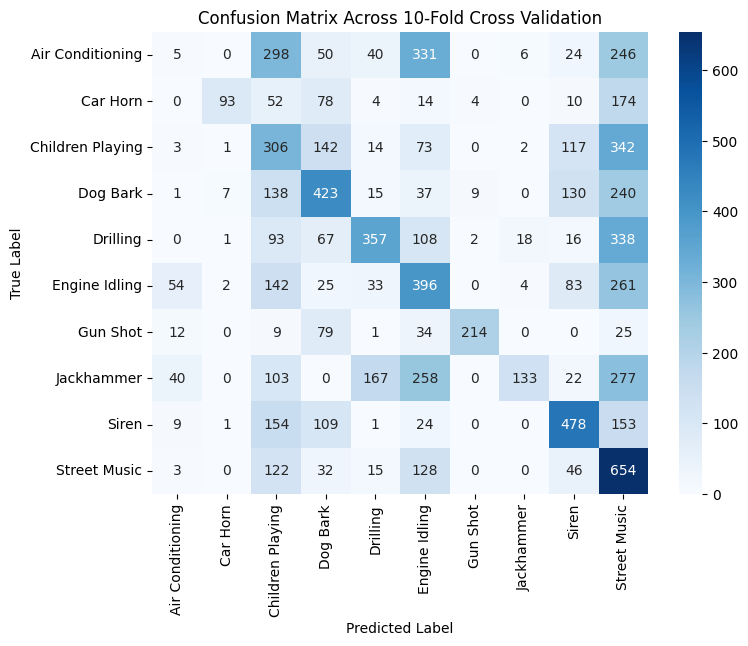

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.04      0.01      0.01      1000
        Car Horn       0.89      0.22      0.35       429
Children Playing       0.22      0.31      0.25      1000
        Dog Bark       0.42      0.42      0.42      1000
        Drilling       0.55      0.36      0.43      1000
   Engine Idling       0.28      0.40      0.33      1000
        Gun Shot       0.93      0.57      0.71       374
      Jackhammer       0.82      0.13      0.23      1000
           Siren       0.52      0.51      0.52       929
    Street Music       0.24      0.65      0.35      1000

        accuracy                           0.35      8732
       macro avg       0.49      0.36      0.36      8732
    weighted avg       0.43      0.35      0.33      8732



In [10]:
class_names = ['Air Conditioning', 'Car Horn', 'Children Playing', 'Dog Bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']
# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

It's not a surprise that the more complex model led to a longer runtime, 56 minutes.  As can be seen in the accuracy and loss printed on each epoch, the slower learning rate paired with the regularization (batch normalization and dropout) has necessitated more epochs for the model to reach max performance.  All parameters of the new model will remain the same, and the model will be fit with 20 epochs to give the model more steps to minimize loss and lead to greater performance.

Training on Fold 1 as validation set...
Epoch 1/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 125ms/step - accuracy: 0.1706 - loss: 262.8304
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1884 - loss: 199.7401
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.2382 - loss: 180.2962
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.2620 - loss: 168.5190
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2825 - loss: 146.0136
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3119 - loss: 121.8642
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.3378 - loss: 93.1285
Epoch 8/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.3186 - loss: 92.0582
Epoch 9/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3425 - loss: 71.4414
Epoch 10/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3609 - loss: 60.9397
Epoch 11/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/st

2025-04-05 11:43:30.125713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.1673 - loss: 281.4912
Epoch 2/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2112 - loss: 217.2802
Epoch 3/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.2374 - loss: 188.5178
Epoch 4/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.2873 - loss: 147.7253
Epoch 5/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.3035 - loss: 129.6602
Epoch 6/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3192 - loss: 115.6385
Epoch 7/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3278 - loss: 87.6966
Epoch 8/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3307 - loss: 74.6480
Epoch 9/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3522 - loss: 59.9167
Epoch 10/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3582 - loss: 47.8506
Epoch 11/20
246/246 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3542 - loss: 45.7034
Epoch 12/20
2

2025-04-05 11:53:42.426656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


244/244 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.1657 - loss: 281.3705
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 127s 522ms/step - accuracy: 0.1918 - loss: 200.1908
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 766s 3s/step - accuracy: 0.2431 - loss: 171.0403
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.2869 - loss: 128.6668
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 134s 549ms/step - accuracy: 0.3063 - loss: 118.2981
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - accuracy: 0.3159 - loss: 95.9957
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.3636 - loss: 77.2939
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 38s 156ms/step - accuracy: 0.3705 - loss: 62.1263
Epoch 9/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 31s 126ms/step - accuracy: 0.3729 - loss: 54.0769
Epoch 10/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.3807 - loss: 48.4889
Epoch 11/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.3924 - loss: 39.8867
Epoch 12/20
244/

2025-04-05 12:34:00.881293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


242/242 ━━━━━━━━━━━━━━━━━━━━ 818s 3s/step - accuracy: 0.1804 - loss: 281.0132
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 80s 331ms/step - accuracy: 0.2369 - loss: 223.2857
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.2715 - loss: 183.4678
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2768 - loss: 153.3804
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.3129 - loss: 131.5843
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.3411 - loss: 105.3532
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.3422 - loss: 83.9246
Epoch 8/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.3729 - loss: 62.5868
Epoch 9/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 30s 125ms/step - accuracy: 0.3738 - loss: 52.0930
Epoch 10/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.3682 - loss: 45.9769
Epoch 11/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.3747 - loss: 41.3408
Epoch 12/20
242/242 ━

2025-04-05 13:23:47.392152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


244/244 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.1475 - loss: 256.6121
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 59s 244ms/step - accuracy: 0.2216 - loss: 195.3433
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - accuracy: 0.2664 - loss: 165.6968
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.2934 - loss: 131.9047
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.3219 - loss: 103.5755
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.3370 - loss: 90.2696
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 217s 893ms/step - accuracy: 0.3548 - loss: 79.5205
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 77s 316ms/step - accuracy: 0.3718 - loss: 60.3602
Epoch 9/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.3633 - loss: 53.3980
Epoch 10/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 36s 147ms/step - accuracy: 0.4023 - loss: 45.7950
Epoch 11/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 38s 154ms/step - accuracy: 0.3889 - loss: 41.8226
Epoch 12/20
244

2025-04-05 13:47:12.786064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


248/248 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - accuracy: 0.1510 - loss: 249.2490
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.1986 - loss: 177.2786
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.2385 - loss: 146.6928
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.2705 - loss: 113.4959
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2940 - loss: 97.8381
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3309 - loss: 82.4849
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3304 - loss: 67.1782
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3480 - loss: 61.1481
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3634 - loss: 49.1641
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3688 - loss: 49.2587
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3841 - loss: 40.6553
Epoch 12/20
248

2025-04-05 14:09:48.572241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


247/247 ━━━━━━━━━━━━━━━━━━━━ 34s 128ms/step - accuracy: 0.1831 - loss: 266.8641
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.1982 - loss: 204.0448
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2441 - loss: 189.5908
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2574 - loss: 167.3240
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.2672 - loss: 146.4012
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.3001 - loss: 126.0558
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.2987 - loss: 109.6614
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.3187 - loss: 92.4092
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.3256 - loss: 79.8716
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.3248 - loss: 66.8376
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.3198 - loss: 58.1574
Epoch 12/20


2025-04-05 14:20:10.164230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


248/248 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - accuracy: 0.1384 - loss: 262.9700
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.1857 - loss: 190.4639
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2275 - loss: 164.4075
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2741 - loss: 122.7215
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2987 - loss: 101.1565
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3031 - loss: 87.2597
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3373 - loss: 82.0781
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3384 - loss: 72.7677
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3595 - loss: 57.2558
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3577 - loss: 53.5172
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.3797 - loss: 42.8221
Epoch 12/20
24

2025-04-05 14:30:21.348758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


248/248 ━━━━━━━━━━━━━━━━━━━━ 35s 124ms/step - accuracy: 0.1489 - loss: 281.9786
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2038 - loss: 215.2421
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.2386 - loss: 196.2146
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.2755 - loss: 163.0974
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2896 - loss: 135.8200
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3275 - loss: 107.0290
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.3276 - loss: 92.1169
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.3596 - loss: 75.2399
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 125ms/step - accuracy: 0.3575 - loss: 60.0322
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.3454 - loss: 62.4856
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.3773 - loss: 44.8740
Epoch 12/20
2

2025-04-05 14:40:37.003031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


247/247 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy: 0.1479 - loss: 340.0131
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - accuracy: 0.1993 - loss: 223.6956
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2514 - loss: 172.0816
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 122ms/step - accuracy: 0.2705 - loss: 150.8256
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.2747 - loss: 130.2065
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.2978 - loss: 112.8543
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3168 - loss: 90.6560
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3292 - loss: 79.4636
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3471 - loss: 66.4001
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3668 - loss: 55.8597
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.3670 - loss: 49.9385
Epoch 12/20
2

2025-04-05 14:50:49.225305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


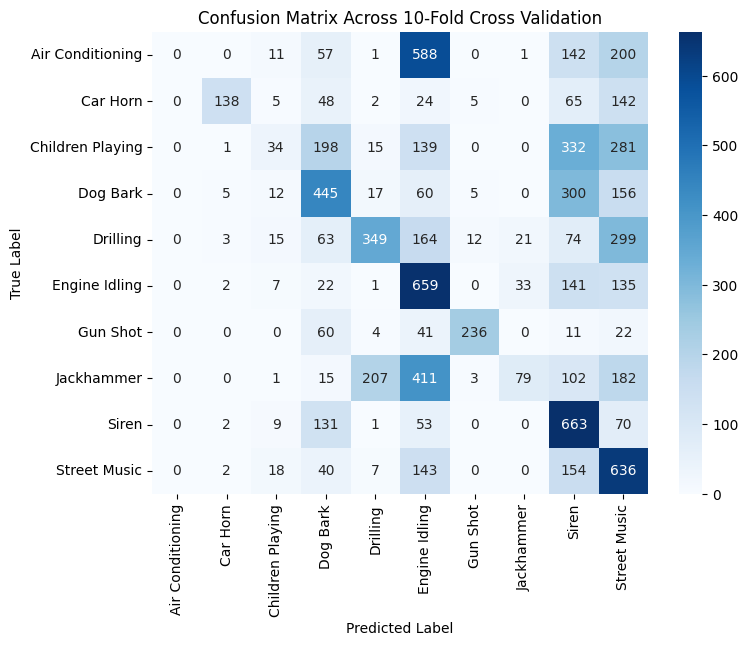

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.00      0.00      0.00      1000
        Car Horn       0.90      0.32      0.47       429
Children Playing       0.30      0.03      0.06      1000
        Dog Bark       0.41      0.45      0.43      1000
        Drilling       0.58      0.35      0.44      1000
   Engine Idling       0.29      0.66      0.40      1000
        Gun Shot       0.90      0.63      0.74       374
      Jackhammer       0.59      0.08      0.14      1000
           Siren       0.33      0.71      0.46       929
    Street Music       0.30      0.64      0.41      1000

        accuracy                           0.37      8732
       macro avg       0.46      0.39      0.35      8732
    weighted avg       0.40      0.37      0.32      8732



/Users/sarahpfeifer/Documents/Python Code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarahpfeifer/Documents/Python Code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sarahpfeifer/Documents/Python Code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [11]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(32).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model()

    # Train model
    model.fit(train_ds, epochs=20)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

The model still seems not to have converged, and it has definitely not overfit, as the validation accuracy is higher than most epochs of the training accuracy.  Next the batch size will be increased to 64 which should lead to faster training.  20 epochs will still be used.  If this has a negative affect on model performance, I will decrease the learning rate and/or lower the batch size because the model is probably stuck in a local minimum.

Training on Fold 1 as validation set...
Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 32s 231ms/step - accuracy: 0.1359 - loss: 294.0729
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.1686 - loss: 256.8012
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.1987 - loss: 237.6177
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2271 - loss: 212.5264
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.2396 - loss: 194.2219
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.2501 - loss: 173.3854
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.2785 - loss: 146.8364
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2898 - loss: 133.8053
Epoch 9/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3060 - loss: 113.4827
Epoch 10/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3117 - loss: 106.4281
Epoch 11/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227m

2025-04-05 15:00:32.742736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 231ms/step - accuracy: 0.1274 - loss: 335.0160
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 927s 8s/step - accuracy: 0.1414 - loss: 292.2341
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.1549 - loss: 283.7841
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.1722 - loss: 266.1338
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.1926 - loss: 199.6103
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 217ms/step - accuracy: 0.2142 - loss: 155.7339
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.2387 - loss: 124.7829
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.2504 - loss: 107.1943
Epoch 9/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.2738 - loss: 97.1562
Epoch 10/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 217ms/step - accuracy: 0.2869 - loss: 78.7558
Epoch 11/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 34s 276ms/step - accuracy: 0.2933 - loss: 71.8461
Epoch 12/20
123/123

2025-04-05 15:38:20.383175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 33s 249ms/step - accuracy: 0.1395 - loss: 304.0673
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 232ms/step - accuracy: 0.1914 - loss: 258.7269
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 233ms/step - accuracy: 0.2206 - loss: 252.8387
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 230ms/step - accuracy: 0.2150 - loss: 241.6630
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2382 - loss: 211.2279
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2775 - loss: 192.3488
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2849 - loss: 156.5630
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3155 - loss: 140.7237
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 230ms/step - accuracy: 0.3227 - loss: 125.4384
Epoch 10/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 231ms/step - accuracy: 0.3327 - loss: 114.4254
Epoch 11/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 233ms/step - accuracy: 0.3505 - loss: 100.1610
Epoch 12

2025-04-05 15:47:45.048442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 233ms/step - accuracy: 0.1439 - loss: 301.2069
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 229ms/step - accuracy: 0.1833 - loss: 239.5981
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 226ms/step - accuracy: 0.2238 - loss: 234.2298
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.2515 - loss: 202.2027
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.2585 - loss: 204.2667
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2851 - loss: 168.0839
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.3057 - loss: 155.2706
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.3074 - loss: 144.6928
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.3279 - loss: 116.3241
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.3289 - loss: 108.0571
Epoch 11/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.3613 - loss: 87.8865
Epoch 12/

2025-04-05 15:56:54.633155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.1436 - loss: 271.2684
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.1564 - loss: 219.7498
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.1855 - loss: 190.1100
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2125 - loss: 163.9532
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2346 - loss: 152.8911
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2444 - loss: 127.9888
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2680 - loss: 110.2796
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2852 - loss: 92.7646
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.3028 - loss: 80.7820
Epoch 10/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.3200 - loss: 70.8624
Epoch 11/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - accuracy: 0.3403 - loss: 67.7342
Epoch 12/20


2025-04-05 16:06:21.678506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 238ms/step - accuracy: 0.1375 - loss: 288.7512
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.1869 - loss: 238.7501
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2170 - loss: 204.0135
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2368 - loss: 179.7687
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2652 - loss: 154.4590
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2836 - loss: 137.4193
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2983 - loss: 124.3812
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2999 - loss: 119.3878
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3111 - loss: 110.7751
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3269 - loss: 97.4843
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3394 - loss: 85.9067

2025-04-05 16:15:48.328423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 225ms/step - accuracy: 0.1401 - loss: 298.6024
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.1693 - loss: 250.0950
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.1962 - loss: 229.0945
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.2296 - loss: 197.1923
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.2493 - loss: 173.5607
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2691 - loss: 153.5078
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.2857 - loss: 150.7123
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.2907 - loss: 131.6391
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3023 - loss: 122.8185
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3138 - loss: 106.5462
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3256 - loss: 94.3902
Epoch 12/

2025-04-05 16:25:05.741365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 232ms/step - accuracy: 0.1368 - loss: 323.3368
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.1868 - loss: 239.7294
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2070 - loss: 209.4638
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2330 - loss: 192.1526
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2611 - loss: 160.9498
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2783 - loss: 150.7938
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2796 - loss: 131.5765
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3014 - loss: 118.0523
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2928 - loss: 111.8375
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3163 - loss: 100.8098
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.3196 - loss: 86.8896
Epoch 12/

2025-04-05 16:34:31.003233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 236ms/step - accuracy: 0.1097 - loss: 288.8070
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.1583 - loss: 246.5650
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.1823 - loss: 223.9940
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2210 - loss: 173.4284
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2378 - loss: 161.0246
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2379 - loss: 145.2332
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2675 - loss: 126.9101
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2923 - loss: 104.8596
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3136 - loss: 91.3083
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3166 - loss: 81.0620
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3399 - loss: 67.2967
Epoch 12/20

2025-04-05 16:43:52.693619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - accuracy: 0.1082 - loss: 405.6859
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.1789 - loss: 282.7211
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.2134 - loss: 252.4084
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2413 - loss: 232.3674
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2671 - loss: 206.0559
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2819 - loss: 185.5599
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2941 - loss: 160.2136
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2953 - loss: 146.0252
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3228 - loss: 130.9036
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3291 - loss: 116.7502
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3447 - loss: 104.4941
Epoch 12

2025-04-05 16:53:12.197958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


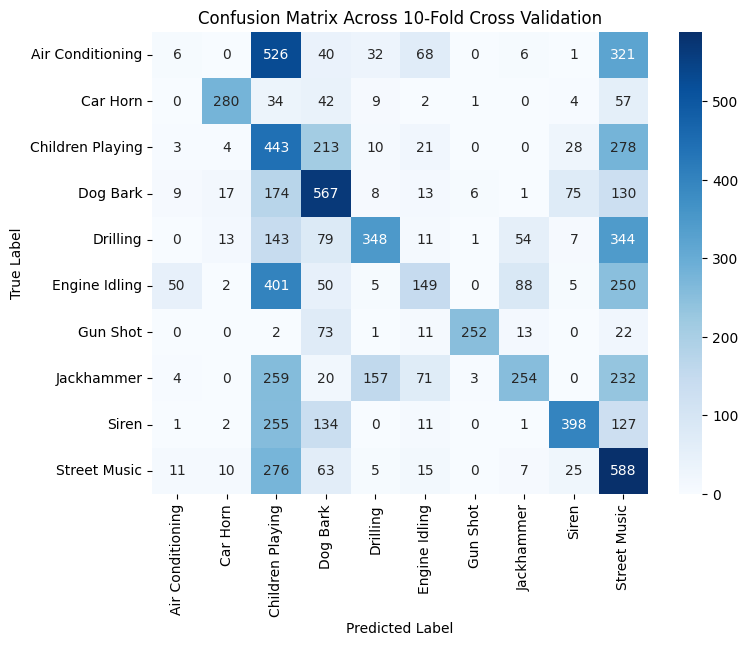

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.07      0.01      0.01      1000
        Car Horn       0.85      0.65      0.74       429
Children Playing       0.18      0.44      0.25      1000
        Dog Bark       0.44      0.57      0.50      1000
        Drilling       0.61      0.35      0.44      1000
   Engine Idling       0.40      0.15      0.22      1000
        Gun Shot       0.96      0.67      0.79       374
      Jackhammer       0.60      0.25      0.36      1000
           Siren       0.73      0.43      0.54       929
    Street Music       0.25      0.59      0.35      1000

        accuracy                           0.38      8732
       macro avg       0.51      0.41      0.42      8732
    weighted avg       0.45      0.38      0.37      8732



In [12]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model()

    # Train model
    model.fit(train_ds, epochs=20)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Enlarging the batch size to 64 had little affect on the performance of the model.  The runtime was faster at 122 min.  Next I will try 128 batch size and see if it changes anything.

Training on Fold 1 as validation set...
Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 489ms/step - accuracy: 0.1210 - loss: 324.1724
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 487ms/step - accuracy: 0.1552 - loss: 280.0319
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 491ms/step - accuracy: 0.1771 - loss: 256.4408
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - accuracy: 0.1869 - loss: 232.0354
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 481ms/step - accuracy: 0.2219 - loss: 221.3255
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 489ms/step - accuracy: 0.2370 - loss: 198.9680
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 486ms/step - accuracy: 0.2529 - loss: 188.7670
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.2771 - loss: 178.7773
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 35s 555ms/step - accuracy: 0.3027 - loss: 166.9155
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 594ms/step - accuracy: 0.3030 - loss: 161.2584
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 553ms/step - accuracy: 0.3

2025-04-05 17:09:38.971890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 507ms/step - accuracy: 0.1294 - loss: 265.1151
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 508ms/step - accuracy: 0.1800 - loss: 225.4831
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 513ms/step - accuracy: 0.2058 - loss: 210.0391
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - accuracy: 0.2277 - loss: 194.5998
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 521ms/step - accuracy: 0.2423 - loss: 182.7578
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 587ms/step - accuracy: 0.2703 - loss: 182.3759
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 620ms/step - accuracy: 0.2920 - loss: 157.4391
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 576ms/step - accuracy: 0.3186 - loss: 136.5439
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 543ms/step - accuracy: 0.3298 - loss: 132.2854
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 522ms/step - accuracy: 0.3484 - loss: 111.1885
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 513ms/step - accuracy: 0.3649 - loss: 108.4444
Epoch 12/20
62/62 ━━━━━━━━━━━━

2025-04-05 17:24:16.376078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 493ms/step - accuracy: 0.1107 - loss: 341.0017
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 59s 964ms/step - accuracy: 0.2140 - loss: 254.0509
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 485ms/step - accuracy: 0.2308 - loss: 238.3732
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 40s 651ms/step - accuracy: 0.2528 - loss: 220.8898
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 496ms/step - accuracy: 0.2585 - loss: 209.5805
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 508ms/step - accuracy: 0.2875 - loss: 191.3151
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 534ms/step - accuracy: 0.2976 - loss: 182.8063
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 545ms/step - accuracy: 0.3365 - loss: 169.0565
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 519ms/step - accuracy: 0.3384 - loss: 165.7386
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 513ms/step - accuracy: 0.3577 - loss: 142.6941
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.3686 - loss: 134.0121
Epoch 12/20
61/61 ━━━━━━━━━━━━

2025-04-05 17:35:13.369197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 506ms/step - accuracy: 0.1272 - loss: 262.1204
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.1952 - loss: 236.6604
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 501ms/step - accuracy: 0.2140 - loss: 234.8818
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 498ms/step - accuracy: 0.2559 - loss: 213.5865
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 502ms/step - accuracy: 0.2848 - loss: 206.1542
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 501ms/step - accuracy: 0.3140 - loss: 177.6696
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 502ms/step - accuracy: 0.3147 - loss: 168.5192
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.3265 - loss: 171.9974
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 495ms/step - accuracy: 0.3398 - loss: 153.1929
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 497ms/step - accuracy: 0.3465 - loss: 151.5426
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 30s 493ms/step - accuracy: 0.3978 - loss: 130.6276
Epoch 12/20
61/61 ━━━━━━━━━━━━

2025-04-05 17:52:39.718809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 632ms/step - accuracy: 0.1580 - loss: 201.4450
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 538ms/step - accuracy: 0.1985 - loss: 209.3774
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 812s 14s/step - accuracy: 0.2023 - loss: 204.6167
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 530ms/step - accuracy: 0.2283 - loss: 211.2122
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 513ms/step - accuracy: 0.2567 - loss: 189.1053
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 511ms/step - accuracy: 0.2742 - loss: 155.6750
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 515ms/step - accuracy: 0.2916 - loss: 139.5661
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 516ms/step - accuracy: 0.3145 - loss: 133.4086
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 529ms/step - accuracy: 0.3463 - loss: 117.1152
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 608ms/step - accuracy: 0.3612 - loss: 105.1861
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 39s 639ms/step - accuracy: 0.3873 - loss: 94.3422
Epoch 12/20
61/61 ━━━━━━━━━━━━━━

2025-04-05 18:16:49.008743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 541ms/step - accuracy: 0.1440 - loss: 275.4393
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 523ms/step - accuracy: 0.1952 - loss: 233.5400
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 521ms/step - accuracy: 0.2198 - loss: 229.0441
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 527ms/step - accuracy: 0.2369 - loss: 207.9467
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 522ms/step - accuracy: 0.2859 - loss: 203.3752
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 523ms/step - accuracy: 0.3034 - loss: 179.9495
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 520ms/step - accuracy: 0.3122 - loss: 170.0172
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 524ms/step - accuracy: 0.3314 - loss: 170.7408
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 521ms/step - accuracy: 0.3544 - loss: 151.8599
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 518ms/step - accuracy: 0.3288 - loss: 158.5515
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 522ms/step - accuracy: 0.3755 - loss: 139.9495
Epoch 12/20
62/62 ━━━━━━━━━━━━

2025-04-05 18:29:47.092818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 35s 530ms/step - accuracy: 0.1351 - loss: 311.9809
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 517ms/step - accuracy: 0.1777 - loss: 275.8405
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 519ms/step - accuracy: 0.1761 - loss: 293.6501
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 519ms/step - accuracy: 0.1998 - loss: 253.5620
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 530ms/step - accuracy: 0.2240 - loss: 209.4233
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 608ms/step - accuracy: 0.2282 - loss: 196.3253
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 669ms/step - accuracy: 0.2632 - loss: 171.2547
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 599ms/step - accuracy: 0.2668 - loss: 160.6177
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 553ms/step - accuracy: 0.2881 - loss: 147.3598
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 534ms/step - accuracy: 0.2930 - loss: 127.8286
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 522ms/step - accuracy: 0.3042 - loss: 118.4830
Epoch 12/20
62/62 ━━━━━━━━━━━━

2025-04-05 18:41:04.715639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 540ms/step - accuracy: 0.1128 - loss: 285.8564
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 525ms/step - accuracy: 0.1973 - loss: 236.9610
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - accuracy: 0.2093 - loss: 233.0066
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 516ms/step - accuracy: 0.2346 - loss: 206.4817
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 515ms/step - accuracy: 0.2353 - loss: 202.9219
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 511ms/step - accuracy: 0.2776 - loss: 175.4146
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 510ms/step - accuracy: 0.3035 - loss: 161.9801
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 511ms/step - accuracy: 0.3248 - loss: 142.3716
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - accuracy: 0.3274 - loss: 146.6956
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - accuracy: 0.3417 - loss: 146.4840
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 513ms/step - accuracy: 0.3562 - loss: 125.7212
Epoch 12/20
62/62 ━━━━━━━━━━━━

2025-04-05 18:51:54.024044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 35s 525ms/step - accuracy: 0.1580 - loss: 220.8655
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 516ms/step - accuracy: 0.1730 - loss: 248.9876
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 516ms/step - accuracy: 0.1937 - loss: 209.6337
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 517ms/step - accuracy: 0.2170 - loss: 206.4567
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 520ms/step - accuracy: 0.2240 - loss: 192.6147
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 519ms/step - accuracy: 0.2514 - loss: 175.3892
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 520ms/step - accuracy: 0.2362 - loss: 171.9199
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 517ms/step - accuracy: 0.2509 - loss: 149.0109
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 515ms/step - accuracy: 0.2667 - loss: 128.1837
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 516ms/step - accuracy: 0.2712 - loss: 117.8531
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 513ms/step - accuracy: 0.2830 - loss: 107.2435
Epoch 12/20
62/62 ━━━━━━━━━━━━

2025-04-05 19:02:43.622319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 538ms/step - accuracy: 0.1117 - loss: 269.2335
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - accuracy: 0.1797 - loss: 228.9854
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - accuracy: 0.2000 - loss: 222.0064
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 513ms/step - accuracy: 0.2205 - loss: 211.3598
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 533ms/step - accuracy: 0.2518 - loss: 204.3457
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 538ms/step - accuracy: 0.2681 - loss: 187.6611
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 543ms/step - accuracy: 0.2898 - loss: 175.1367
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 547ms/step - accuracy: 0.3247 - loss: 157.5384
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 541ms/step - accuracy: 0.3513 - loss: 140.6685
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 545ms/step - accuracy: 0.3586 - loss: 130.4909
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 544ms/step - accuracy: 0.3667 - loss: 119.7295
Epoch 12/20
62/62 ━━━━━━━━━━━━

2025-04-05 19:13:58.242847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


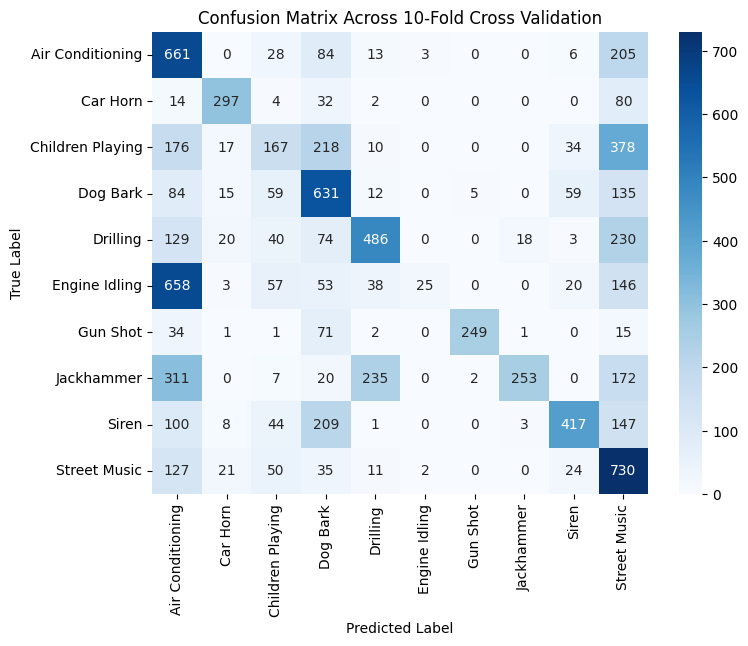

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.29      0.66      0.40      1000
        Car Horn       0.78      0.69      0.73       429
Children Playing       0.37      0.17      0.23      1000
        Dog Bark       0.44      0.63      0.52      1000
        Drilling       0.60      0.49      0.54      1000
   Engine Idling       0.83      0.03      0.05      1000
        Gun Shot       0.97      0.67      0.79       374
      Jackhammer       0.92      0.25      0.40      1000
           Siren       0.74      0.45      0.56       929
    Street Music       0.33      0.73      0.45      1000

        accuracy                           0.45      8732
       macro avg       0.63      0.48      0.47      8732
    weighted avg       0.59      0.45      0.43      8732



In [13]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(128).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(128).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model()

    # Train model
    model.fit(train_ds, epochs=20)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

In [10]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(128).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(128).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model()

    # Train model
    model.fit(train_ds, epochs=30)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...


2025-04-05 22:53:23.803008: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-04-05 22:53:23.803042: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-05 22:53:23.803045: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-04-05 22:53:23.803068: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-05 22:53:23.803084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2025-04-05 22:53:24.531644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 422ms/step - accuracy: 0.1063 - loss: 285.9911
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 438ms/step - accuracy: 0.1864 - loss: 261.8694
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 436ms/step - accuracy: 0.2127 - loss: 255.0926
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 437ms/step - accuracy: 0.2393 - loss: 262.1617
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 438ms/step - accuracy: 0.2425 - loss: 241.9480
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 438ms/step - accuracy: 0.2671 - loss: 215.3314
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 440ms/step - accuracy: 0.2787 - loss: 195.7808
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 441ms/step - accuracy: 0.2934 - loss: 175.7531
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 443ms/step - accuracy: 0.3200 - loss: 167.7395
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 465ms/step - accuracy: 0.3171 - loss: 156.7559
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 488ms/step - accuracy: 0.3293 - loss: 147.6948
Epoch 12/30
62/62 ━━━━━━━━━━━━

2025-04-05 23:07:05.046751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 430ms/step - accuracy: 0.1244 - loss: 353.3855
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 425ms/step - accuracy: 0.1923 - loss: 231.1452
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 425ms/step - accuracy: 0.2020 - loss: 202.1153
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 426ms/step - accuracy: 0.2267 - loss: 188.6684
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 425ms/step - accuracy: 0.2712 - loss: 178.3260
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 426ms/step - accuracy: 0.2852 - loss: 161.3714
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 426ms/step - accuracy: 0.3066 - loss: 148.7446
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 428ms/step - accuracy: 0.3429 - loss: 134.5656
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 424ms/step - accuracy: 0.3453 - loss: 129.1827
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 424ms/step - accuracy: 0.3862 - loss: 114.3399
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 424ms/step - accuracy: 0.3838 - loss: 111.7645
Epoch 12/30
62/62 ━━━━━━━━━━━━

2025-04-05 23:20:21.385307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


61/61 ━━━━━━━━━━━━━━━━━━━━ 29s 435ms/step - accuracy: 0.1029 - loss: 342.9267
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 434ms/step - accuracy: 0.1703 - loss: 300.1595
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 434ms/step - accuracy: 0.2084 - loss: 279.6850
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 434ms/step - accuracy: 0.2186 - loss: 256.3977
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 435ms/step - accuracy: 0.2423 - loss: 237.3539
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 437ms/step - accuracy: 0.2471 - loss: 232.9166
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 435ms/step - accuracy: 0.2759 - loss: 217.0049
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 438ms/step - accuracy: 0.2861 - loss: 192.9315
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 436ms/step - accuracy: 0.3005 - loss: 205.8427
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 437ms/step - accuracy: 0.3114 - loss: 174.3255
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 435ms/step - accuracy: 0.3203 - loss: 173.0463
Epoch 12/30
61/61 ━━━━━━━━━━━━

2025-04-05 23:33:47.951972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


61/61 ━━━━━━━━━━━━━━━━━━━━ 28s 434ms/step - accuracy: 0.1113 - loss: 326.8871
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 426ms/step - accuracy: 0.1772 - loss: 254.7964
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 428ms/step - accuracy: 0.1981 - loss: 237.6026
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 429ms/step - accuracy: 0.2340 - loss: 221.7888
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 431ms/step - accuracy: 0.2554 - loss: 199.6541
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 429ms/step - accuracy: 0.2673 - loss: 191.9633
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.2989 - loss: 188.9682
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 422ms/step - accuracy: 0.3128 - loss: 189.0426
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 967s 16s/step - accuracy: 0.3325 - loss: 170.3968
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 415ms/step - accuracy: 0.3485 - loss: 155.9305
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 419ms/step - accuracy: 0.3646 - loss: 146.9781
Epoch 12/30
61/61 ━━━━━━━━━━━━━━━

2025-04-06 01:12:10.665177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


61/61 ━━━━━━━━━━━━━━━━━━━━ 28s 427ms/step - accuracy: 0.1680 - loss: 202.8830
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 429ms/step - accuracy: 0.1852 - loss: 198.6270
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 428ms/step - accuracy: 0.1882 - loss: 186.1346
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 28s 464ms/step - accuracy: 0.2021 - loss: 168.6892
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 507ms/step - accuracy: 0.2045 - loss: 166.6430
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 32s 526ms/step - accuracy: 0.2397 - loss: 147.9358
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 971s 16s/step - accuracy: 0.2640 - loss: 128.4328
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 423ms/step - accuracy: 0.2912 - loss: 120.0233
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 425ms/step - accuracy: 0.3048 - loss: 98.9952
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - accuracy: 0.3193 - loss: 91.0151
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 420ms/step - accuracy: 0.3360 - loss: 80.1430
Epoch 12/30
61/61 ━━━━━━━━━━━━━━━━━━

2025-04-06 02:33:44.056272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 424ms/step - accuracy: 0.1004 - loss: 366.3351
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 422ms/step - accuracy: 0.1872 - loss: 238.5876
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 423ms/step - accuracy: 0.1977 - loss: 227.5209
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 427ms/step - accuracy: 0.2491 - loss: 211.9387
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.2779 - loss: 194.3444
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 525ms/step - accuracy: 0.2801 - loss: 187.3527
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 978s 16s/step - accuracy: 0.3232 - loss: 168.5453
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 422ms/step - accuracy: 0.3389 - loss: 164.7902
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 969s 16s/step - accuracy: 0.3612 - loss: 151.0479
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 421ms/step - accuracy: 0.3705 - loss: 136.8207
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 424ms/step - accuracy: 0.3823 - loss: 133.4547
Epoch 12/30
62/62 ━━━━━━━━━━━━━━

2025-04-06 04:11:23.878073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 421ms/step - accuracy: 0.1379 - loss: 292.5693
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 421ms/step - accuracy: 0.1823 - loss: 253.6012
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 422ms/step - accuracy: 0.1957 - loss: 235.1992
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 422ms/step - accuracy: 0.2138 - loss: 219.5282
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 424ms/step - accuracy: 0.2400 - loss: 207.0305
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 475ms/step - accuracy: 0.2614 - loss: 178.0653
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 501ms/step - accuracy: 0.2708 - loss: 180.0068
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 940s 15s/step - accuracy: 0.2991 - loss: 160.4090
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 419ms/step - accuracy: 0.3102 - loss: 139.9530
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 419ms/step - accuracy: 0.3223 - loss: 135.7063
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 422ms/step - accuracy: 0.3438 - loss: 124.1738
Epoch 12/30
62/62 ━━━━━━━━━━━━━

2025-04-06 05:15:05.998883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 421ms/step - accuracy: 0.1050 - loss: 339.7861
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.1661 - loss: 272.3503
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 422ms/step - accuracy: 0.1730 - loss: 257.2747
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 421ms/step - accuracy: 0.1773 - loss: 225.4598
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 425ms/step - accuracy: 0.1966 - loss: 216.9698
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 428ms/step - accuracy: 0.2263 - loss: 196.8092
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 472ms/step - accuracy: 0.2331 - loss: 197.4970
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 515ms/step - accuracy: 0.2474 - loss: 183.8897
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 830s 14s/step - accuracy: 0.2641 - loss: 160.8432
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 423ms/step - accuracy: 0.2928 - loss: 146.3556
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 423ms/step - accuracy: 0.3021 - loss: 126.3970
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━

2025-04-06 06:31:59.151842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 427ms/step - accuracy: 0.1587 - loss: 256.6379
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 450ms/step - accuracy: 0.1673 - loss: 247.8998
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 496ms/step - accuracy: 0.1962 - loss: 222.6044
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 32s 521ms/step - accuracy: 0.2131 - loss: 195.9586
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 957s 16s/step - accuracy: 0.2310 - loss: 184.2717
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 421ms/step - accuracy: 0.2310 - loss: 173.8514
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 422ms/step - accuracy: 0.2799 - loss: 151.4949
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 439ms/step - accuracy: 0.2743 - loss: 144.6010
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 424ms/step - accuracy: 0.3058 - loss: 138.3776
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 423ms/step - accuracy: 0.3124 - loss: 130.6241
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 487ms/step - accuracy: 0.3262 - loss: 122.3456
Epoch 12/30
62/62 ━━━━━━━━━━━━━

2025-04-06 07:30:24.071215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 433ms/step - accuracy: 0.1021 - loss: 325.7311
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 433ms/step - accuracy: 0.1741 - loss: 265.2184
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 435ms/step - accuracy: 0.1847 - loss: 249.0774
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 433ms/step - accuracy: 0.1935 - loss: 247.7355
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 434ms/step - accuracy: 0.2300 - loss: 219.4462
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 438ms/step - accuracy: 0.2531 - loss: 198.1451
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 447ms/step - accuracy: 0.2707 - loss: 179.5267
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - accuracy: 0.2915 - loss: 155.7834
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 443ms/step - accuracy: 0.2989 - loss: 154.2870
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 440ms/step - accuracy: 0.2980 - loss: 150.2820
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 438ms/step - accuracy: 0.3257 - loss: 123.7693
Epoch 12/30
62/62 ━━━━━━━━━━━━

2025-04-06 07:43:57.799280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


NameError: name 'class_names' is not defined

<Figure size 800x600 with 0 Axes>

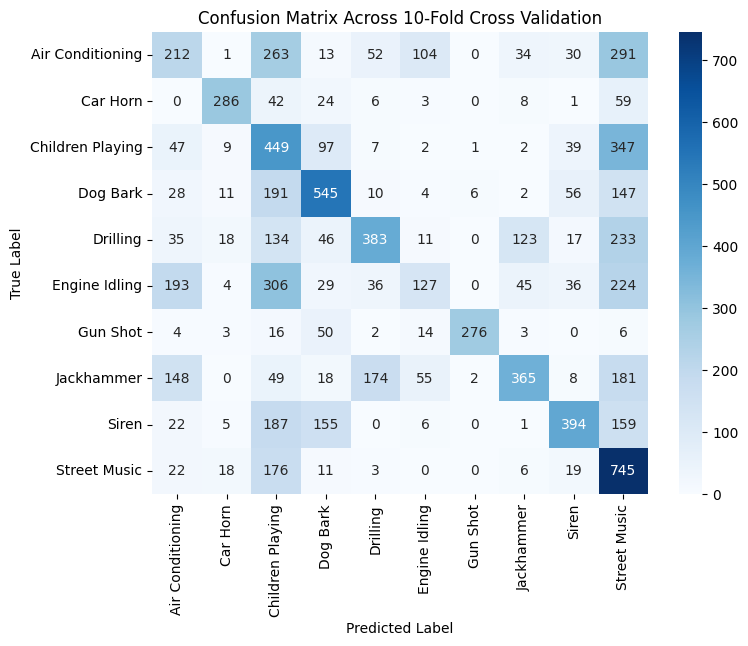

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.30      0.21      0.25      1000
        Car Horn       0.81      0.67      0.73       429
Children Playing       0.25      0.45      0.32      1000
        Dog Bark       0.55      0.55      0.55      1000
        Drilling       0.57      0.38      0.46      1000
   Engine Idling       0.39      0.13      0.19      1000
        Gun Shot       0.97      0.74      0.84       374
      Jackhammer       0.62      0.36      0.46      1000
           Siren       0.66      0.42      0.52       929
    Street Music       0.31      0.74      0.44      1000

        accuracy                           0.43      8732
       macro avg       0.54      0.47      0.47      8732
    weighted avg       0.49      0.43      0.43      8732



In [11]:
class_names = ['Air Conditioning', 'Car Horn', 'Children Playing', 'Dog Bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']
# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Increasing to 30 epochs did not help accuracy.  The model is now overfitting, and still not performing as well as the initial simple model.  I will slow the learning rate down, and take out the dropout layers and see how that affects the model.  The epochs will be reduced to 25,  I'm unsure the magnitude of the effect of lowering learning rate by 10^-1 vs removing all 3 dropout layers.  I can adjust learning rate and/or epochs according to the results of this model.

Training on Fold 1 as validation set...
Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 404ms/step - accuracy: 0.1736 - loss: 16.9166
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 401ms/step - accuracy: 0.3580 - loss: 5.9667
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.4410 - loss: 3.5116
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.4983 - loss: 2.5134
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 403ms/step - accuracy: 0.4984 - loss: 2.4453
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.5205 - loss: 2.2120
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.5250 - loss: 2.1500
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.5110 - loss: 1.9893
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 418ms/step - accuracy: 0.5325 - loss: 1.9716
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - accuracy: 0.5543 - loss: 1.7789
Epoch 11/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 475ms/step - accuracy: 0.6152 - loss: 1.5126


2025-04-06 08:08:02.626258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 412ms/step - accuracy: 0.1952 - loss: 19.6568
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.3628 - loss: 4.3709
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 410ms/step - accuracy: 0.4108 - loss: 2.6416
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.4299 - loss: 2.5299
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.4797 - loss: 1.9977
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 400ms/step - accuracy: 0.5342 - loss: 1.8820
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 399ms/step - accuracy: 0.4929 - loss: 1.9573
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 398ms/step - accuracy: 0.5632 - loss: 1.6990
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 398ms/step - accuracy: 0.5220 - loss: 1.9092
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 398ms/step - accuracy: 0.5371 - loss: 1.8033
Epoch 11/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 399ms/step - accuracy: 0.4679 - loss: 3.2623
Epoch 12/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 2

2025-04-06 08:18:28.995484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 409ms/step - accuracy: 0.1882 - loss: 24.6257
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.4001 - loss: 3.7802
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.4501 - loss: 2.4708
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.4606 - loss: 2.3881
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.4881 - loss: 2.1131
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.4647 - loss: 2.5369
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.4981 - loss: 2.2386
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.5220 - loss: 1.9048
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.5536 - loss: 1.8617
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.5792 - loss: 1.7785
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.5909 - loss: 1.6096
Epoch 12/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/st

2025-04-06 08:28:57.128891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


61/61 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.2127 - loss: 18.1002
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 401ms/step - accuracy: 0.3724 - loss: 4.0097
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.4638 - loss: 3.0047
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 401ms/step - accuracy: 0.4667 - loss: 2.6617
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.4589 - loss: 2.5084
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.4850 - loss: 2.3949
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - accuracy: 0.5367 - loss: 2.2006
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 401ms/step - accuracy: 0.4933 - loss: 2.4462
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.4836 - loss: 2.6350
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.4626 - loss: 2.6997
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - accuracy: 0.4700 - loss: 3.0826
Epoch 12/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/st

2025-04-06 08:39:16.679686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 409ms/step - accuracy: 0.2425 - loss: 19.0532
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.3726 - loss: 13.1226
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.3865 - loss: 7.8434
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.3928 - loss: 3.5239
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.4204 - loss: 3.2275
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - accuracy: 0.4393 - loss: 2.6447
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.4911 - loss: 2.3312
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 408ms/step - accuracy: 0.5034 - loss: 2.2812
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.4855 - loss: 3.0007
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.4965 - loss: 2.3291
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.4582 - loss: 2.4959
Epoch 12/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/s

2025-04-06 09:01:26.928267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.2089 - loss: 20.8059
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.3745 - loss: 5.5894
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 409ms/step - accuracy: 0.3901 - loss: 3.5090
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 412ms/step - accuracy: 0.4551 - loss: 2.7411
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 412ms/step - accuracy: 0.4549 - loss: 2.4258
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 414ms/step - accuracy: 0.4702 - loss: 2.2839
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 429ms/step - accuracy: 0.5154 - loss: 1.9115
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - accuracy: 0.4895 - loss: 2.1559
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - accuracy: 0.5013 - loss: 2.2538
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 433ms/step - accuracy: 0.5288 - loss: 1.6973
Epoch 11/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 424ms/step - accuracy: 0.5264 - loss: 1.6763
Epoch 12/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 418ms/st

2025-04-06 09:12:20.286041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 410ms/step - accuracy: 0.1831 - loss: 24.0315
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.3413 - loss: 7.9081
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.4082 - loss: 3.9392
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - accuracy: 0.4368 - loss: 3.0167
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 403ms/step - accuracy: 0.4540 - loss: 2.6403
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 403ms/step - accuracy: 0.4203 - loss: 3.0813
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 403ms/step - accuracy: 0.4333 - loss: 3.0315
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 403ms/step - accuracy: 0.4658 - loss: 2.3430
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 403ms/step - accuracy: 0.4788 - loss: 2.0812
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.5162 - loss: 1.7841
Epoch 11/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.4697 - loss: 2.3251
Epoch 12/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 664ms/st

2025-04-06 09:23:42.104158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 419ms/step - accuracy: 0.2023 - loss: 16.3023
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.3977 - loss: 4.7376
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.4273 - loss: 3.3399
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 414ms/step - accuracy: 0.4191 - loss: 2.7957
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.4642 - loss: 2.4142
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 415ms/step - accuracy: 0.4818 - loss: 2.1015
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 416ms/step - accuracy: 0.5095 - loss: 1.8207
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 415ms/step - accuracy: 0.5129 - loss: 1.7934
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.5148 - loss: 1.6609
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.5467 - loss: 1.5280
Epoch 11/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.5511 - loss: 1.5255
Epoch 12/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/st

2025-04-06 09:34:58.479332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.2309 - loss: 13.1271
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 417ms/step - accuracy: 0.3770 - loss: 4.6913
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.4330 - loss: 3.4363
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.4722 - loss: 2.5089
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - accuracy: 0.5050 - loss: 2.1677
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.5160 - loss: 1.8568
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.5047 - loss: 1.9325
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.5408 - loss: 1.8248
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 417ms/step - accuracy: 0.5423 - loss: 1.7141
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - accuracy: 0.5373 - loss: 1.7231
Epoch 11/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 548ms/step - accuracy: 0.5702 - loss: 1.5284
Epoch 12/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 35s 562ms/step -

2025-04-06 09:50:26.143358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 416ms/step - accuracy: 0.1833 - loss: 24.4088
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 410ms/step - accuracy: 0.3324 - loss: 9.8807
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step - accuracy: 0.3591 - loss: 6.2010
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 410ms/step - accuracy: 0.3947 - loss: 4.5755
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 409ms/step - accuracy: 0.4366 - loss: 3.6269
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 409ms/step - accuracy: 0.4589 - loss: 3.5005
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 408ms/step - accuracy: 0.5036 - loss: 3.0762
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 408ms/step - accuracy: 0.4566 - loss: 3.3048
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.4802 - loss: 3.1116
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.5032 - loss: 2.6919
Epoch 11/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.5593 - loss: 2.0285
Epoch 12/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 408ms/st

2025-04-06 10:01:03.567627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


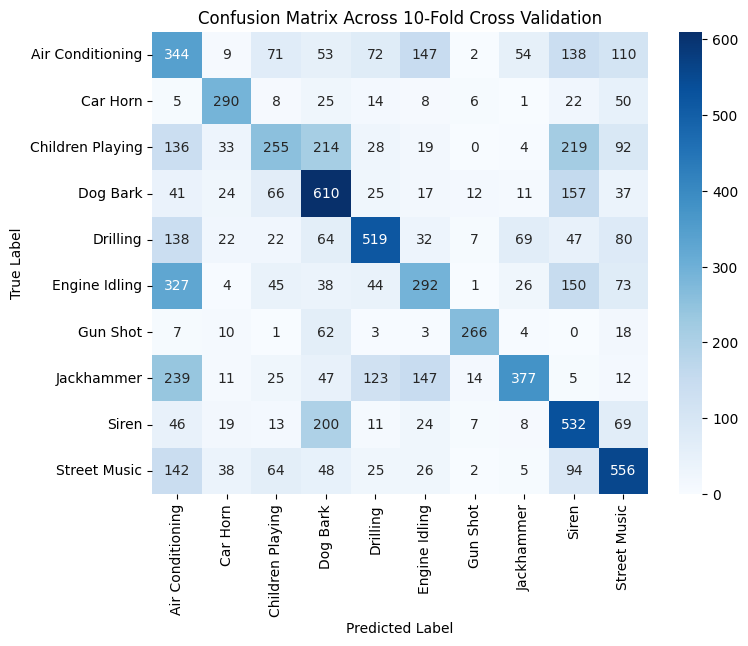

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.24      0.34      0.28      1000
        Car Horn       0.63      0.68      0.65       429
Children Playing       0.45      0.26      0.32      1000
        Dog Bark       0.45      0.61      0.52      1000
        Drilling       0.60      0.52      0.56      1000
   Engine Idling       0.41      0.29      0.34      1000
        Gun Shot       0.84      0.71      0.77       374
      Jackhammer       0.67      0.38      0.48      1000
           Siren       0.39      0.57      0.46       929
    Street Music       0.51      0.56      0.53      1000

        accuracy                           0.46      8732
       macro avg       0.52      0.49      0.49      8732
    weighted avg       0.49      0.46      0.46      8732



In [15]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(128).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(128).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model(
    dropout_rates=[1, 1, 1],
    dense_units=128,
    learning_rate=0.0001,
    activation='relu',
    use_batch_norm=True)

    # Train model
    model.fit(train_ds, epochs=25)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

While the training accuracy reached around 70% the validation avg accuracy was 46% so the model overfit.  I will run the same model with a slower learning rate to see if that improves the accuracy of the validation sets.  I'm also going to lower the batch size to 64 since I'm slowing down learning.

Training on Fold 1 as validation set...
Epoch 1/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - accuracy: 0.2399 - loss: 4.1374
Epoch 2/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 208ms/step - accuracy: 0.3800 - loss: 2.1892
Epoch 3/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.4176 - loss: 1.9246
Epoch 4/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.4468 - loss: 1.7952
Epoch 5/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.4750 - loss: 1.6817
Epoch 6/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.4836 - loss: 1.6482
Epoch 7/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 215ms/step - accuracy: 0.5085 - loss: 1.5607
Epoch 8/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 214ms/step - accuracy: 0.5079 - loss: 1.5374
Epoch 9/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 219ms/step - accuracy: 0.5735 - loss: 1.3630
Epoch 10/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 0.5785 - loss: 1.2979
Epoch 11/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 31s 248ms/step - accuracy: 0

2025-04-06 10:16:26.081765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 214ms/step - accuracy: 0.2241 - loss: 3.9984
Epoch 2/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.4175 - loss: 2.0641
Epoch 3/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.4516 - loss: 1.9164
Epoch 4/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.4805 - loss: 1.7569
Epoch 5/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.4964 - loss: 1.5911
Epoch 6/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.4938 - loss: 1.5892
Epoch 7/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.4945 - loss: 1.6967
Epoch 8/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.5395 - loss: 1.5716
Epoch 9/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.5830 - loss: 1.3388
Epoch 10/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.5828 - loss: 1.3352
Epoch 11/25
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.6129 - loss: 1.2423
Epoch 12/25
123/123 ━━━━━━━━━━

2025-04-06 11:03:30.593550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 207ms/step - accuracy: 0.2095 - loss: 4.0251
Epoch 2/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 103s 851ms/step - accuracy: 0.3935 - loss: 2.1019
Epoch 3/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 206ms/step - accuracy: 0.3889 - loss: 1.8685
Epoch 4/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 454s 4s/step - accuracy: 0.3980 - loss: 1.7880
Epoch 5/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 207ms/step - accuracy: 0.4674 - loss: 1.6530
Epoch 6/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - accuracy: 0.4766 - loss: 1.5486
Epoch 7/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 206ms/step - accuracy: 0.5175 - loss: 1.5089
Epoch 8/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 207ms/step - accuracy: 0.5518 - loss: 1.3801
Epoch 9/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 208ms/step - accuracy: 0.5265 - loss: 1.3715
Epoch 10/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.5682 - loss: 1.2770
Epoch 11/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 32s 260ms/step - accuracy: 0.5812 - loss: 1.2815
Epoch 12/25
122/122 ━━━━━━━━━━━━━

2025-04-06 11:29:20.805243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 216ms/step - accuracy: 0.2258 - loss: 3.7131
Epoch 2/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.3561 - loss: 2.1428
Epoch 3/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.3983 - loss: 1.8706
Epoch 4/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.4322 - loss: 1.7614
Epoch 5/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.4358 - loss: 1.8096
Epoch 6/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.4779 - loss: 1.6050
Epoch 7/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 214ms/step - accuracy: 0.4850 - loss: 1.4579
Epoch 8/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 215ms/step - accuracy: 0.5021 - loss: 1.4915
Epoch 9/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.5289 - loss: 1.3923
Epoch 10/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 273ms/step - accuracy: 0.5588 - loss: 1.3481
Epoch 11/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 26s 217ms/step - accuracy: 0.5720 - loss: 1.2768
Epoch 12/25
121/121 ━━━━━━━━━━

2025-04-06 11:43:31.649119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.2282 - loss: 3.2511
Epoch 2/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 214ms/step - accuracy: 0.3837 - loss: 2.0410
Epoch 3/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.4097 - loss: 1.8671
Epoch 4/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.4353 - loss: 1.7565
Epoch 5/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 215ms/step - accuracy: 0.4642 - loss: 1.6383
Epoch 6/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 215ms/step - accuracy: 0.4725 - loss: 1.6353
Epoch 7/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 214ms/step - accuracy: 0.4657 - loss: 1.7404
Epoch 8/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 214ms/step - accuracy: 0.5194 - loss: 1.4997
Epoch 9/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 214ms/step - accuracy: 0.5315 - loss: 1.4189
Epoch 10/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 214ms/step - accuracy: 0.5642 - loss: 1.3505
Epoch 11/25
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.5955 - loss: 1.2360
Epoch 12/25
122/122 ━━━━━━━━━━

2025-04-06 11:54:26.097260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 216ms/step - accuracy: 0.2278 - loss: 3.8263
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.3227 - loss: 2.2265
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.4355 - loss: 1.7824
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.4477 - loss: 1.7536
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.4644 - loss: 1.6354
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.4668 - loss: 1.6355
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.5128 - loss: 1.4911
Epoch 8/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.5197 - loss: 1.3943
Epoch 9/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.5321 - loss: 1.3807
Epoch 10/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 217ms/step - accuracy: 0.5154 - loss: 1.5079
Epoch 11/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 237ms/step - accuracy: 0.5410 - loss: 1.6141
Epoch 12/25
124/124 ━━━━━━━━━━━━

2025-04-06 12:08:44.744629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 216ms/step - accuracy: 0.2365 - loss: 3.8634
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.3632 - loss: 2.0915
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.4317 - loss: 1.8418
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.4275 - loss: 1.7916
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.4704 - loss: 1.7182
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.4755 - loss: 1.7343
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.4770 - loss: 1.6951
Epoch 8/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.4962 - loss: 1.5531
Epoch 9/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.5347 - loss: 1.4566
Epoch 10/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.5471 - loss: 1.3545
Epoch 11/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.5441 - loss: 1.3645
Epoch 12/25
124/124 ━━━━━━━━━━

2025-04-06 12:19:40.550531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 214ms/step - accuracy: 0.1797 - loss: 4.1071
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.3602 - loss: 1.9957
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.3495 - loss: 1.9995
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.4267 - loss: 1.7910
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.4482 - loss: 1.6742
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.4753 - loss: 1.5749
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.4880 - loss: 1.5708
Epoch 8/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.5076 - loss: 1.5040
Epoch 9/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.5155 - loss: 1.4849
Epoch 10/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.5148 - loss: 1.5321
Epoch 11/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 213ms/step - accuracy: 0.5628 - loss: 1.3683
Epoch 12/25
124/124 ━━━━━━━━━━

2025-04-06 12:34:00.878016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 213ms/step - accuracy: 0.1789 - loss: 3.9090
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.3591 - loss: 2.0940
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.4025 - loss: 1.8315
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.4259 - loss: 1.7079
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 229ms/step - accuracy: 0.4408 - loss: 1.6911
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 34s 275ms/step - accuracy: 0.4803 - loss: 1.5580
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 297ms/step - accuracy: 0.5208 - loss: 1.4424
Epoch 8/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 259ms/step - accuracy: 0.5194 - loss: 1.4870
Epoch 9/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 237ms/step - accuracy: 0.5628 - loss: 1.3703
Epoch 10/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.5708 - loss: 1.4146
Epoch 11/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 219ms/step - accuracy: 0.5702 - loss: 1.4488
Epoch 12/25
124/124 ━━━━━━━━━━

2025-04-06 12:45:49.013172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.2103 - loss: 3.9868
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.3372 - loss: 2.2117
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.3947 - loss: 1.8503
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.4360 - loss: 1.6738
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.4509 - loss: 1.5957
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.4785 - loss: 1.5466
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.4949 - loss: 1.5263
Epoch 8/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.5374 - loss: 1.4225
Epoch 9/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 0.5147 - loss: 1.4827
Epoch 10/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.5507 - loss: 1.3870
Epoch 11/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 26s 211ms/step - accuracy: 0.5552 - loss: 1.3679
Epoch 12/25
124/124 ━━━━━━━━━━

2025-04-06 12:56:51.303545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


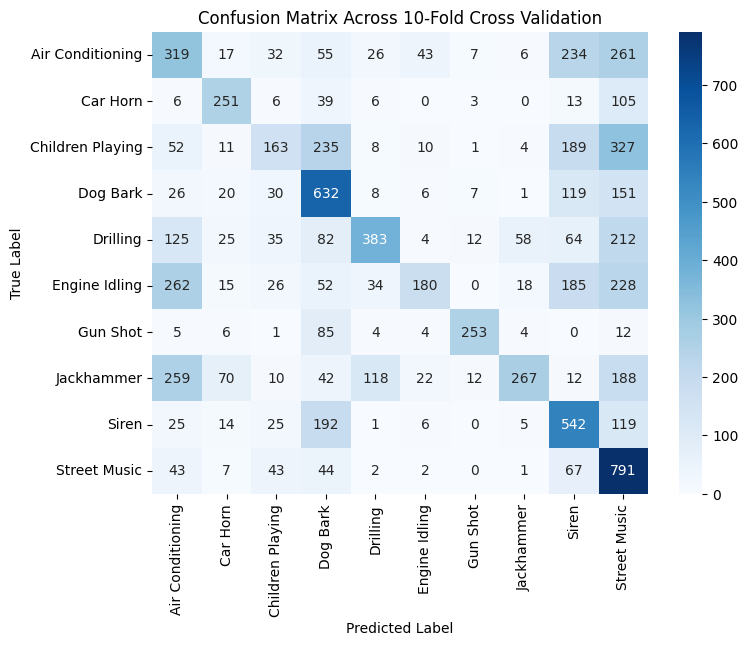

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.28      0.32      0.30      1000
        Car Horn       0.58      0.59      0.58       429
Children Playing       0.44      0.16      0.24      1000
        Dog Bark       0.43      0.63      0.51      1000
        Drilling       0.65      0.38      0.48      1000
   Engine Idling       0.65      0.18      0.28      1000
        Gun Shot       0.86      0.68      0.76       374
      Jackhammer       0.73      0.27      0.39      1000
           Siren       0.38      0.58      0.46       929
    Street Music       0.33      0.79      0.47      1000

        accuracy                           0.43      8732
       macro avg       0.53      0.46      0.45      8732
    weighted avg       0.51      0.43      0.42      8732



In [16]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model(
    dropout_rates=[1, 1, 1],
    dense_units=128,
    learning_rate=0.00001,
    activation='relu',
    use_batch_norm=True)

    # Train model
    model.fit(train_ds, epochs=25)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...
Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 31s 228ms/step - accuracy: 0.1865 - loss: 5.9500
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2734 - loss: 4.4546
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.2828 - loss: 4.6395
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2823 - loss: 4.8039
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 229ms/step - accuracy: 0.3087 - loss: 4.7307
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2919 - loss: 5.1674
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 229ms/step - accuracy: 0.3115 - loss: 5.2455
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3404 - loss: 5.2897
Epoch 9/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 230ms/step - accuracy: 0.3287 - loss: 5.5890
Epoch 10/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3375 - loss: 5.4968
Epoch 11/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 238ms/step - accuracy: 0

2025-04-06 13:08:54.936484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


123/123 ━━━━━━━━━━━━━━━━━━━━ 31s 230ms/step - accuracy: 0.1811 - loss: 5.6137
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2418 - loss: 4.6355
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2545 - loss: 4.8212
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2638 - loss: 4.8017
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2661 - loss: 5.1793
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2854 - loss: 5.1002
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2985 - loss: 5.0429
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3230 - loss: 5.0011
Epoch 9/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3334 - loss: 5.2467
Epoch 10/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3309 - loss: 5.0802
Epoch 11/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3385 - loss: 5.1432
Epoch 12/20
123/123 ━━━━━━━━━━

2025-04-06 13:18:14.993855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.1702 - loss: 5.8376
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2541 - loss: 4.4253
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2634 - loss: 4.8872
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2855 - loss: 4.8866
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2890 - loss: 4.7228
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3069 - loss: 4.6994
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2992 - loss: 4.8353
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 233ms/step - accuracy: 0.3204 - loss: 5.0289
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.3116 - loss: 5.0227
Epoch 10/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 232ms/step - accuracy: 0.3349 - loss: 4.9920
Epoch 11/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 231ms/step - accuracy: 0.3395 - loss: 5.1672
Epoch 12/20
122/122 ━━━━━━━━━━

2025-04-06 13:27:39.381653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


121/121 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.1676 - loss: 5.9343
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2366 - loss: 4.6165
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2509 - loss: 4.6682
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2724 - loss: 4.7492
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.2869 - loss: 4.9291
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.2925 - loss: 5.0016
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.3068 - loss: 4.9667
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.3026 - loss: 5.1630
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.3175 - loss: 4.9814
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.3249 - loss: 5.3712
Epoch 11/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.3148 - loss: 5.5873
Epoch 12/20
121/121 ━━━━━━━━━━

2025-04-06 13:36:46.634222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 228ms/step - accuracy: 0.1786 - loss: 5.2866
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2677 - loss: 4.3226
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2785 - loss: 4.5076
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2836 - loss: 4.8064
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2909 - loss: 4.8228
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.3037 - loss: 4.8754
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.3236 - loss: 4.7407
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.3198 - loss: 4.9045
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3257 - loss: 5.1635
Epoch 10/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 76s 626ms/step - accuracy: 0.3309 - loss: 5.3763
Epoch 11/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.3355 - loss: 5.5307
Epoch 12/20
122/122 ━━━━━━━━━━

2025-04-06 13:46:49.489388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 34s 227ms/step - accuracy: 0.1816 - loss: 5.3011
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.2615 - loss: 4.6962
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.2688 - loss: 4.8012
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.2952 - loss: 4.6849
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.3002 - loss: 4.9207
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.3182 - loss: 4.7805
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 27s 221ms/step - accuracy: 0.3277 - loss: 4.9664
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.3342 - loss: 5.1493
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.3260 - loss: 5.1911
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.3303 - loss: 5.3441
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.3454 - loss: 5.3481
Epoch 12/20
124/124 ━━━━━━━━━━

2025-04-06 13:57:48.173191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 34s 255ms/step - accuracy: 0.1827 - loss: 5.5167
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 241ms/step - accuracy: 0.2499 - loss: 4.6088
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.2781 - loss: 4.4832
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.2820 - loss: 4.7063
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.3006 - loss: 4.6892
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.3087 - loss: 4.9459
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.3147 - loss: 5.0136
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.3182 - loss: 4.9784
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.3209 - loss: 4.8826
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.3456 - loss: 5.0350
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.3456 - loss: 5.1488
Epoch 12/20
124/124 ━━━━━━━━━━

2025-04-06 14:07:26.041930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 229ms/step - accuracy: 0.1496 - loss: 5.7598
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.2265 - loss: 4.8019
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2559 - loss: 4.7789
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.2732 - loss: 4.9575
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2907 - loss: 4.8625
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2826 - loss: 5.2207
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2988 - loss: 5.2205
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2998 - loss: 5.2655
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3178 - loss: 5.2340
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3213 - loss: 5.4096
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3337 - loss: 5.4265
Epoch 12/20
124/124 ━━━━━━━━━━

2025-04-06 14:18:02.187740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 225ms/step - accuracy: 0.1793 - loss: 5.6897
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.2425 - loss: 4.9947
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2545 - loss: 5.1716
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2641 - loss: 5.3778
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2675 - loss: 5.5380
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2816 - loss: 5.6378
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2804 - loss: 5.7800
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 237ms/step - accuracy: 0.3009 - loss: 5.6710
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 35s 285ms/step - accuracy: 0.3053 - loss: 5.6973
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 321ms/step - accuracy: 0.3113 - loss: 5.9458
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 34s 271ms/step - accuracy: 0.3150 - loss: 6.1336
Epoch 12/20
124/124 ━

2025-04-06 14:31:41.210358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 230ms/step - accuracy: 0.1445 - loss: 6.2308
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2593 - loss: 4.8209
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2704 - loss: 4.8072
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.2840 - loss: 4.9721
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2786 - loss: 5.0232
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.2899 - loss: 5.0553
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3165 - loss: 4.8889
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.3180 - loss: 4.9542
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3307 - loss: 5.1599
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3310 - loss: 5.1400
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3361 - loss: 5.3701
Epoch 12/20
124/124 ━━━━━━━━━━━━━━

2025-04-06 14:45:04.613732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


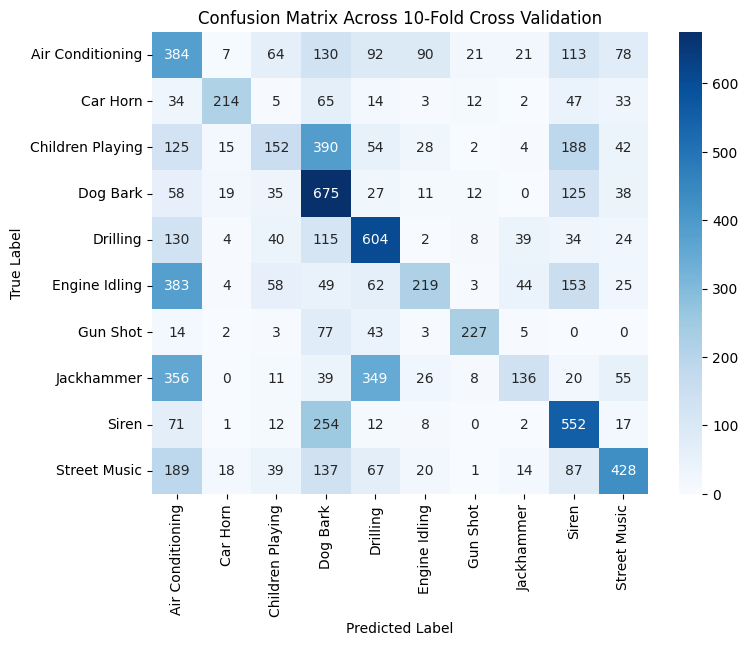

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.22      0.38      0.28      1000
        Car Horn       0.75      0.50      0.60       429
Children Playing       0.36      0.15      0.21      1000
        Dog Bark       0.35      0.68      0.46      1000
        Drilling       0.46      0.60      0.52      1000
   Engine Idling       0.53      0.22      0.31      1000
        Gun Shot       0.77      0.61      0.68       374
      Jackhammer       0.51      0.14      0.21      1000
           Siren       0.42      0.59      0.49       929
    Street Music       0.58      0.43      0.49      1000

        accuracy                           0.41      8732
       macro avg       0.50      0.43      0.43      8732
    weighted avg       0.46      0.41      0.40      8732



In [17]:
# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model(
    dropout_rates=[0.25, 0.25, 0.25],
    dense_units=128,
    learning_rate=0.00001,
    activation='relu',
    use_batch_norm=True)

    # Train model
    model.fit(train_ds, epochs=20)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...


2025-04-06 21:21:52.311352: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-04-06 21:21:52.311378: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-06 21:21:52.311382: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-04-06 21:21:52.311398: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-06 21:21:52.311408: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/60


2025-04-06 21:21:53.003076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 226ms/step - accuracy: 0.1811 - loss: 5.9846
Epoch 2/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 231ms/step - accuracy: 0.2545 - loss: 4.8371
Epoch 3/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.2835 - loss: 4.9356
Epoch 4/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.3039 - loss: 5.0649
Epoch 5/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 230ms/step - accuracy: 0.3133 - loss: 4.9363
Epoch 6/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 235ms/step - accuracy: 0.3261 - loss: 5.0682
Epoch 7/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 237ms/step - accuracy: 0.3223 - loss: 5.0592
Epoch 8/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 239ms/step - accuracy: 0.3415 - loss: 5.0816
Epoch 9/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 32s 256ms/step - accuracy: 0.3550 - loss: 5.1641
Epoch 10/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - accuracy: 0.3546 - loss: 5.3398
Epoch 11/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 34s 274ms/step - accuracy: 0.3521 - loss: 5.6517
Epoch 12/60
123/123 ━━━━━━━━━━

2025-04-06 21:50:51.896108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.1743 - loss: 5.7749
Epoch 2/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2581 - loss: 4.5809
Epoch 3/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2796 - loss: 4.5522
Epoch 4/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3022 - loss: 4.5658
Epoch 5/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3042 - loss: 4.6795
Epoch 6/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3003 - loss: 4.7305
Epoch 7/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3215 - loss: 4.8162
Epoch 8/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3139 - loss: 5.1045
Epoch 9/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3432 - loss: 5.1153
Epoch 10/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3353 - loss: 5.0081
Epoch 11/60
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3495 - loss: 5.2128
Epoch 12/60
123/123 ━━━━━━━━━━

2025-04-06 22:18:48.704305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.1769 - loss: 6.1841
Epoch 2/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2430 - loss: 5.0587
Epoch 3/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2826 - loss: 5.0050
Epoch 4/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2750 - loss: 5.4130
Epoch 5/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2937 - loss: 5.2403
Epoch 6/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2994 - loss: 5.4625
Epoch 7/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3090 - loss: 5.4355
Epoch 8/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3257 - loss: 5.3938
Epoch 9/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3218 - loss: 5.6816
Epoch 10/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3335 - loss: 5.5268
Epoch 11/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 229ms/step - accuracy: 0.3447 - loss: 5.6983
Epoch 12/60
122/122 ━━━━━━━━━━

2025-04-06 22:46:42.509306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


121/121 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - accuracy: 0.1807 - loss: 5.6701
Epoch 2/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2576 - loss: 4.6853
Epoch 3/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 227ms/step - accuracy: 0.2846 - loss: 4.6790
Epoch 4/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 227ms/step - accuracy: 0.2813 - loss: 4.8513
Epoch 5/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2960 - loss: 5.0573
Epoch 6/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3060 - loss: 4.9886
Epoch 7/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3113 - loss: 5.4176
Epoch 8/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3181 - loss: 5.3235
Epoch 9/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3348 - loss: 5.1899
Epoch 10/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3485 - loss: 5.1207
Epoch 11/60
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3399 - loss: 5.3594
Epoch 12/60
121/121 ━━━━━━━━━━

2025-04-06 23:14:15.071943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 225ms/step - accuracy: 0.1741 - loss: 5.5593
Epoch 2/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.2575 - loss: 4.7134
Epoch 3/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.2532 - loss: 5.1686
Epoch 4/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.2733 - loss: 5.0379
Epoch 5/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.2862 - loss: 5.4250
Epoch 6/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2934 - loss: 5.5978
Epoch 7/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3097 - loss: 5.4536
Epoch 8/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3137 - loss: 5.6389
Epoch 9/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3041 - loss: 5.9894
Epoch 10/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3253 - loss: 5.6273
Epoch 11/60
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.3380 - loss: 5.7857
Epoch 12/60
122/122 ━━━━━━━━━━

2025-04-06 23:41:41.138018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - accuracy: 0.2005 - loss: 5.2419
Epoch 2/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.2616 - loss: 4.7018
Epoch 3/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.2786 - loss: 4.5110
Epoch 4/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.2928 - loss: 4.5894
Epoch 5/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3006 - loss: 4.8190
Epoch 6/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2881 - loss: 5.2235
Epoch 7/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3137 - loss: 4.9691
Epoch 8/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3326 - loss: 4.8304
Epoch 9/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.3399 - loss: 4.8070
Epoch 10/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3263 - loss: 5.3120
Epoch 11/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3446 - loss: 5.0023
Epoch 12/60
124/124 ━━━━━━━━━━

2025-04-07 00:09:26.073551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - accuracy: 0.1858 - loss: 5.6054
Epoch 2/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2491 - loss: 4.5612
Epoch 3/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2650 - loss: 4.8570
Epoch 4/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2823 - loss: 4.8808
Epoch 5/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2857 - loss: 5.1284
Epoch 6/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2955 - loss: 5.2339
Epoch 7/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3079 - loss: 5.2241
Epoch 8/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3145 - loss: 5.4278
Epoch 9/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3286 - loss: 5.2015
Epoch 10/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3218 - loss: 5.4298
Epoch 11/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3205 - loss: 5.6634
Epoch 12/60
124/124 ━━━━━━━━━━

2025-04-07 00:37:21.563109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 229ms/step - accuracy: 0.1599 - loss: 5.8431
Epoch 2/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2260 - loss: 5.2409
Epoch 3/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2532 - loss: 5.1629
Epoch 4/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2519 - loss: 5.5553
Epoch 5/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2740 - loss: 5.3387
Epoch 6/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2816 - loss: 5.5481
Epoch 7/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2972 - loss: 5.5432
Epoch 8/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2998 - loss: 5.6570
Epoch 9/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2955 - loss: 5.8684
Epoch 10/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3157 - loss: 5.6173
Epoch 11/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3106 - loss: 5.9832
Epoch 12/60
124/124 ━━━━━━━━━━

2025-04-07 01:05:32.271547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 228ms/step - accuracy: 0.1797 - loss: 5.4028
Epoch 2/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2470 - loss: 4.5485
Epoch 3/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2502 - loss: 4.7412
Epoch 4/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2611 - loss: 4.9889
Epoch 5/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2866 - loss: 5.1988
Epoch 6/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2994 - loss: 5.2064
Epoch 7/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3070 - loss: 5.2409
Epoch 8/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3062 - loss: 5.2804
Epoch 9/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3140 - loss: 5.5060
Epoch 10/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3276 - loss: 5.3869
Epoch 11/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3210 - loss: 5.3675
Epoch 12/60
124/124 ━━━━━━━━━━

2025-04-07 01:33:35.862551: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.1293 - loss: 5.9271
Epoch 2/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2440 - loss: 4.8280
Epoch 3/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2595 - loss: 4.8240
Epoch 4/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2780 - loss: 4.6323
Epoch 5/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2959 - loss: 4.7136
Epoch 6/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3046 - loss: 4.8957
Epoch 7/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3150 - loss: 4.8408
Epoch 8/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3214 - loss: 4.9428
Epoch 9/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3264 - loss: 4.9056
Epoch 10/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3130 - loss: 5.3765
Epoch 11/60
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3200 - loss: 5.4967
Epoch 12/60
124/124 ━━━━━━━━━━

2025-04-07 02:01:29.850042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


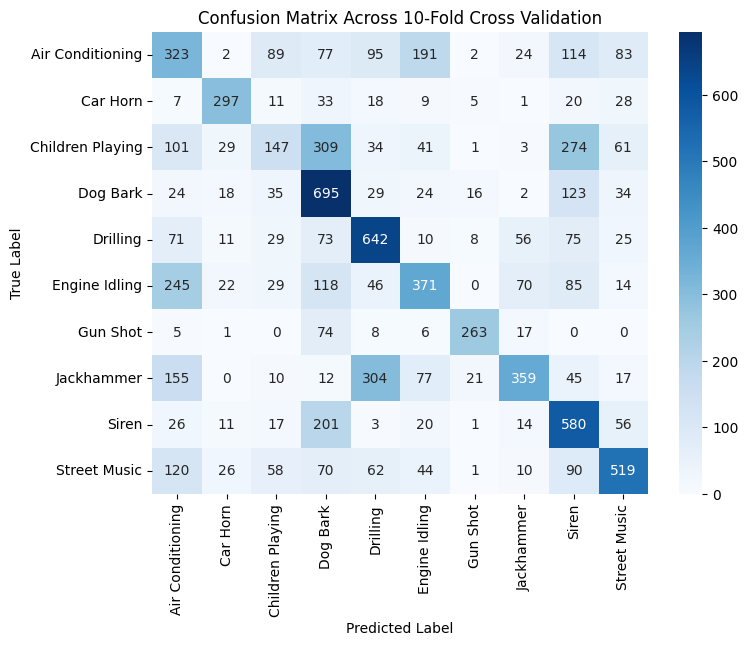

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.30      0.32      0.31      1000
        Car Horn       0.71      0.69      0.70       429
Children Playing       0.35      0.15      0.21      1000
        Dog Bark       0.42      0.69      0.52      1000
        Drilling       0.52      0.64      0.57      1000
   Engine Idling       0.47      0.37      0.41      1000
        Gun Shot       0.83      0.70      0.76       374
      Jackhammer       0.65      0.36      0.46      1000
           Siren       0.41      0.62      0.50       929
    Street Music       0.62      0.52      0.57      1000

        accuracy                           0.48      8732
       macro avg       0.53      0.51      0.50      8732
    weighted avg       0.49      0.48      0.47      8732



In [7]:
class_names = ['Air Conditioning', 'Car Horn', 'Children Playing', 'Dog Bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model(
    dropout_rates=[0.25, 0.25, 0.25],
    dense_units=128,
    learning_rate=0.00001,
    activation='relu',
    use_batch_norm=True)

    # Train model
    model.fit(train_ds, epochs=60)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...
Epoch 1/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.1523 - loss: 6.2191
Epoch 2/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - accuracy: 0.2498 - loss: 4.8190
Epoch 3/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.2609 - loss: 4.9478
Epoch 4/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2776 - loss: 4.7873
Epoch 5/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2761 - loss: 5.1350
Epoch 6/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2951 - loss: 5.0131
Epoch 7/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3107 - loss: 4.9962
Epoch 8/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3094 - loss: 5.2986
Epoch 9/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3320 - loss: 5.2093
Epoch 10/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3513 - loss: 5.2284
Epoch 11/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0

2025-04-07 07:16:06.592080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


123/123 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - accuracy: 0.1650 - loss: 6.0514
Epoch 2/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2510 - loss: 4.8118
Epoch 3/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2778 - loss: 4.8489
Epoch 4/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2998 - loss: 4.6478
Epoch 5/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2892 - loss: 4.9582
Epoch 6/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3115 - loss: 4.9725
Epoch 7/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3168 - loss: 4.8474
Epoch 8/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3335 - loss: 4.9281
Epoch 9/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3336 - loss: 5.1535
Epoch 10/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3221 - loss: 5.4570
Epoch 11/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3514 - loss: 5.3874
Epoch 12/80
123/123 ━━━━━━━━━━

2025-04-07 07:53:09.124815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.1938 - loss: 5.2997
Epoch 2/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2564 - loss: 4.5382
Epoch 3/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2621 - loss: 4.8535
Epoch 4/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2847 - loss: 4.7843
Epoch 5/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2963 - loss: 4.7439
Epoch 6/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3025 - loss: 4.8147
Epoch 7/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3056 - loss: 5.0234
Epoch 8/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3122 - loss: 5.4094
Epoch 9/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3369 - loss: 5.2427
Epoch 10/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3438 - loss: 5.1741
Epoch 11/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3518 - loss: 5.0203
Epoch 12/80
122/122 ━━━━━━━━━━

2025-04-07 08:30:08.319075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


121/121 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.1836 - loss: 5.8243
Epoch 2/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 226ms/step - accuracy: 0.2735 - loss: 4.4374
Epoch 3/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2724 - loss: 4.6176
Epoch 4/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2889 - loss: 4.6503
Epoch 5/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2908 - loss: 5.1227
Epoch 6/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3000 - loss: 5.0960
Epoch 7/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 227ms/step - accuracy: 0.3323 - loss: 4.9384
Epoch 8/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3129 - loss: 5.1016
Epoch 9/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 227ms/step - accuracy: 0.3230 - loss: 5.4573
Epoch 10/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 227ms/step - accuracy: 0.3428 - loss: 5.4036
Epoch 11/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3508 - loss: 5.3834
Epoch 12/80
121/121 ━━━━━━━━━━

2025-04-07 09:06:51.358104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - accuracy: 0.1770 - loss: 5.1387
Epoch 2/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2542 - loss: 4.3896
Epoch 3/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2507 - loss: 4.6401
Epoch 4/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2741 - loss: 4.7753
Epoch 5/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2768 - loss: 5.1392
Epoch 6/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2980 - loss: 4.8881
Epoch 7/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3040 - loss: 5.2250
Epoch 8/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3053 - loss: 5.1144
Epoch 9/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3081 - loss: 5.6848
Epoch 10/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3247 - loss: 5.4262
Epoch 11/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3222 - loss: 5.7576
Epoch 12/80
122/122 ━━━━━━━━━━

2025-04-07 09:43:53.931880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - accuracy: 0.1752 - loss: 5.7156
Epoch 2/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2494 - loss: 4.9844
Epoch 3/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2861 - loss: 4.9608
Epoch 4/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2746 - loss: 5.2646
Epoch 5/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3026 - loss: 5.0344
Epoch 6/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3152 - loss: 5.3099
Epoch 7/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3289 - loss: 5.2388
Epoch 8/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3258 - loss: 5.2379
Epoch 9/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3324 - loss: 5.5176
Epoch 10/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3399 - loss: 5.4042
Epoch 11/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3594 - loss: 5.6100
Epoch 12/80
124/124 ━━━━━━━━━━

2025-04-07 10:21:08.854665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - accuracy: 0.1929 - loss: 5.9837
Epoch 2/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.2467 - loss: 4.9634
Epoch 3/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2642 - loss: 4.9103
Epoch 4/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2829 - loss: 4.9183
Epoch 5/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2890 - loss: 4.8877
Epoch 6/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3138 - loss: 4.9603
Epoch 7/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3194 - loss: 5.0923
Epoch 8/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3299 - loss: 5.1485
Epoch 9/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3395 - loss: 5.1522
Epoch 10/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3466 - loss: 5.3449
Epoch 11/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3535 - loss: 5.4973
Epoch 12/80
124/124 ━━━━━━━━━━

2025-04-07 10:58:14.038053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 230ms/step - accuracy: 0.1495 - loss: 6.2917
Epoch 2/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2327 - loss: 5.0258
Epoch 3/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2717 - loss: 4.8500
Epoch 4/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2887 - loss: 5.0015
Epoch 5/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2854 - loss: 5.2136
Epoch 6/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3029 - loss: 5.1190
Epoch 7/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3124 - loss: 5.2324
Epoch 8/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3148 - loss: 5.4356
Epoch 9/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3268 - loss: 5.5954
Epoch 10/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3286 - loss: 5.7956
Epoch 11/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3321 - loss: 5.5809
Epoch 12/80
124/124 ━━━━━━━━━━

2025-04-07 11:35:36.645297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.1710 - loss: 5.5432
Epoch 2/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2302 - loss: 5.0362
Epoch 3/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2444 - loss: 5.0843
Epoch 4/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2563 - loss: 5.3195
Epoch 5/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2832 - loss: 5.3187
Epoch 6/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2799 - loss: 5.4467
Epoch 7/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2929 - loss: 5.5167
Epoch 8/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3079 - loss: 5.6439
Epoch 9/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3276 - loss: 5.6209
Epoch 10/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3190 - loss: 5.7009
Epoch 11/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3365 - loss: 5.6113
Epoch 12/80
124/124 ━━━━━━━━━━

2025-04-07 12:12:57.090257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 228ms/step - accuracy: 0.1482 - loss: 5.8406
Epoch 2/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2484 - loss: 4.8656
Epoch 3/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2584 - loss: 5.0150
Epoch 4/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2665 - loss: 4.9890
Epoch 5/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2774 - loss: 4.9768
Epoch 6/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2853 - loss: 5.2812
Epoch 7/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3093 - loss: 5.0440
Epoch 8/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3005 - loss: 5.6069
Epoch 9/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3217 - loss: 5.4981
Epoch 10/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3157 - loss: 5.5797
Epoch 11/80
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3339 - loss: 5.4079
Epoch 12/80
124/124 ━━━━━━━━━━

2025-04-07 12:50:10.510845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


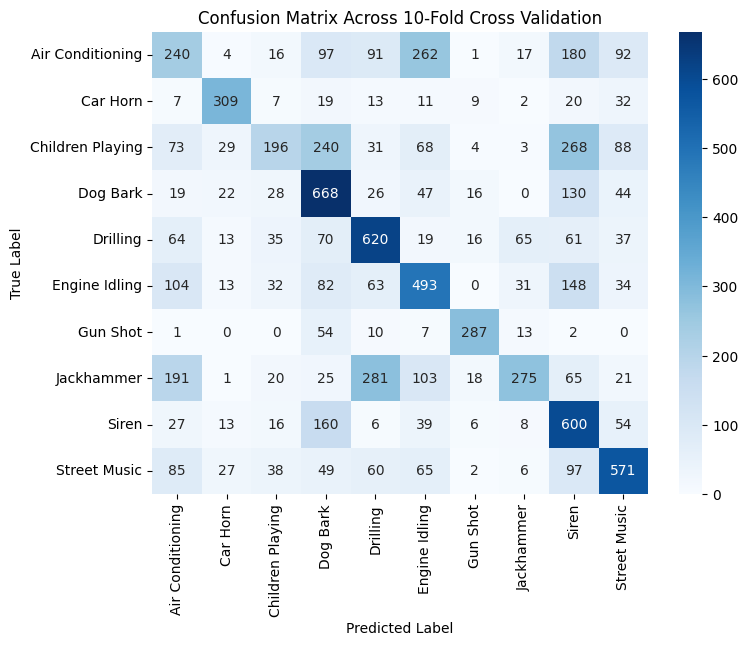

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.30      0.24      0.27      1000
        Car Horn       0.72      0.72      0.72       429
Children Playing       0.51      0.20      0.28      1000
        Dog Bark       0.46      0.67      0.54      1000
        Drilling       0.52      0.62      0.56      1000
   Engine Idling       0.44      0.49      0.47      1000
        Gun Shot       0.80      0.77      0.78       374
      Jackhammer       0.65      0.28      0.39      1000
           Siren       0.38      0.65      0.48       929
    Street Music       0.59      0.57      0.58      1000

        accuracy                           0.49      8732
       macro avg       0.54      0.52      0.51      8732
    weighted avg       0.51      0.49      0.47      8732



In [8]:
class_names = ['Air Conditioning', 'Car Horn', 'Children Playing', 'Dog Bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model(
    dropout_rates=[0.25, 0.25, 0.25],
    dense_units=128,
    learning_rate=0.00001,
    activation='relu',
    use_batch_norm=True)

    # Train model
    model.fit(train_ds, epochs=80)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...


2025-04-08 06:05:12.671671: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-04-08 06:05:12.671695: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-08 06:05:12.671698: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-04-08 06:05:12.671717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-08 06:05:12.671737: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/150


2025-04-08 06:05:13.358201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 220ms/step - accuracy: 0.1547 - loss: 5.9942
Epoch 2/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.2526 - loss: 4.9109
Epoch 3/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 230ms/step - accuracy: 0.2834 - loss: 4.9687
Epoch 4/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 231ms/step - accuracy: 0.2866 - loss: 5.1475
Epoch 5/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.2805 - loss: 5.5099
Epoch 6/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.3200 - loss: 5.3258
Epoch 7/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.3107 - loss: 5.5357
Epoch 8/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 0.3153 - loss: 5.5194
Epoch 9/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 237ms/step - accuracy: 0.3274 - loss: 5.8226
Epoch 10/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 238ms/step - accuracy: 0.3455 - loss: 5.5921
Epoch 11/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 0.3323 - loss: 5.8396
Epoch 12/150
123/123

2025-04-08 07:16:17.300621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 232ms/step - accuracy: 0.1586 - loss: 5.7669
Epoch 2/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2617 - loss: 4.6237
Epoch 3/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2681 - loss: 5.0072
Epoch 4/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2775 - loss: 5.0216
Epoch 5/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2992 - loss: 4.9649
Epoch 6/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3252 - loss: 4.9902
Epoch 7/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3298 - loss: 5.0291
Epoch 8/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3327 - loss: 5.2375
Epoch 9/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3287 - loss: 5.2155
Epoch 10/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.3407 - loss: 5.1615
Epoch 11/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3647 - loss: 4.9138
Epoch 12/150
123/123

2025-04-08 08:25:25.961403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - accuracy: 0.1654 - loss: 5.4925
Epoch 2/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.2495 - loss: 4.4276
Epoch 3/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.2501 - loss: 4.7796
Epoch 4/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.2729 - loss: 4.8190
Epoch 5/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.2901 - loss: 4.6921
Epoch 6/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.2997 - loss: 4.9076
Epoch 7/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.2992 - loss: 5.2200
Epoch 8/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3108 - loss: 5.2502
Epoch 9/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3220 - loss: 5.5124
Epoch 10/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.3313 - loss: 5.6453
Epoch 11/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.3477 - loss: 5.4908
Epoch 12/150
122/122

2025-04-08 09:34:14.738853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


121/121 ━━━━━━━━━━━━━━━━━━━━ 29s 226ms/step - accuracy: 0.1652 - loss: 5.7595
Epoch 2/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.2672 - loss: 4.4644
Epoch 3/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.2777 - loss: 4.5373
Epoch 4/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.3014 - loss: 4.7221
Epoch 5/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.3002 - loss: 4.8731
Epoch 6/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.3177 - loss: 4.6289
Epoch 7/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 226ms/step - accuracy: 0.3176 - loss: 4.8305
Epoch 8/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 226ms/step - accuracy: 0.3346 - loss: 4.8498
Epoch 9/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.3231 - loss: 5.2613
Epoch 10/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.3424 - loss: 4.9194
Epoch 11/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.3441 - loss: 5.1891
Epoch 12/150
121/121

2025-04-08 10:42:29.512275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


122/122 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.1693 - loss: 5.4349
Epoch 2/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.2471 - loss: 4.5903
Epoch 3/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.2597 - loss: 4.8184
Epoch 4/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - accuracy: 0.2728 - loss: 5.0156
Epoch 5/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.2856 - loss: 5.0195
Epoch 6/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3040 - loss: 4.9054
Epoch 7/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.2918 - loss: 5.3418
Epoch 8/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.2973 - loss: 5.3316
Epoch 9/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.3208 - loss: 5.3430
Epoch 10/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.3172 - loss: 5.2546
Epoch 11/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 224ms/step - accuracy: 0.3213 - loss: 5.3396
Epoch 12/150
122/122

2025-04-08 11:51:03.880559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - accuracy: 0.1420 - loss: 5.9702
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2494 - loss: 4.5846
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2753 - loss: 4.7068
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2786 - loss: 4.8118
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2949 - loss: 4.8884
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2937 - loss: 5.0322
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2942 - loss: 5.1484
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2997 - loss: 5.2735
Epoch 9/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3224 - loss: 5.3631
Epoch 10/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3350 - loss: 5.2870
Epoch 11/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3227 - loss: 5.6557
Epoch 12/150
124/124

2025-04-08 13:01:08.686570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - accuracy: 0.1640 - loss: 5.2687
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2694 - loss: 4.2871
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.2921 - loss: 4.4095
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2897 - loss: 4.5140
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2998 - loss: 4.5242
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3021 - loss: 4.5730
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step - accuracy: 0.2971 - loss: 4.8620
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3247 - loss: 4.9273
Epoch 9/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3319 - loss: 4.8630
Epoch 10/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3418 - loss: 4.8539
Epoch 11/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3380 - loss: 5.0038
Epoch 12/150
124/124

2025-04-08 14:11:21.656494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 31s 227ms/step - accuracy: 0.1356 - loss: 5.8612
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2357 - loss: 4.5876
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2762 - loss: 4.5719
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2771 - loss: 4.5318
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2873 - loss: 4.7118
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3086 - loss: 4.7847
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3105 - loss: 4.8062
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3062 - loss: 5.3777
Epoch 9/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3164 - loss: 5.2595
Epoch 10/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3294 - loss: 5.2381
Epoch 11/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.3251 - loss: 5.5144
Epoch 12/150
124/124

2025-04-08 15:21:15.411709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - accuracy: 0.1633 - loss: 5.5521
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2270 - loss: 4.9420
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2459 - loss: 5.0828
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 224ms/step - accuracy: 0.2563 - loss: 5.0637
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2659 - loss: 5.2464
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2663 - loss: 5.4376
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2910 - loss: 5.4808
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3019 - loss: 5.3543
Epoch 9/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2965 - loss: 5.6529
Epoch 10/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2958 - loss: 5.7225
Epoch 11/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3055 - loss: 5.8405
Epoch 12/150
124/124

2025-04-08 16:31:16.248687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


124/124 ━━━━━━━━━━━━━━━━━━━━ 30s 227ms/step - accuracy: 0.1634 - loss: 5.6171
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2517 - loss: 4.6469
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.2737 - loss: 4.4730
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2735 - loss: 4.8895
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3078 - loss: 4.6308
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.2965 - loss: 4.9597
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3092 - loss: 5.2017
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3308 - loss: 4.9982
Epoch 9/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.3111 - loss: 5.3893
Epoch 10/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 227ms/step - accuracy: 0.3227 - loss: 5.4420
Epoch 11/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3260 - loss: 5.5779
Epoch 12/150
124/124

2025-04-08 17:41:17.993525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


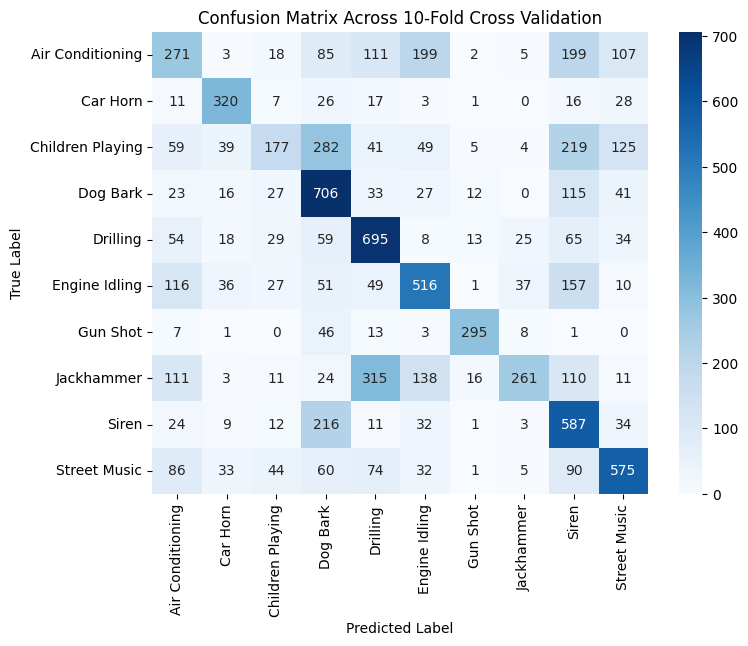

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.36      0.27      0.31      1000
        Car Horn       0.67      0.75      0.71       429
Children Playing       0.50      0.18      0.26      1000
        Dog Bark       0.45      0.71      0.55      1000
        Drilling       0.51      0.69      0.59      1000
   Engine Idling       0.51      0.52      0.51      1000
        Gun Shot       0.85      0.79      0.82       374
      Jackhammer       0.75      0.26      0.39      1000
           Siren       0.38      0.63      0.47       929
    Street Music       0.60      0.57      0.59      1000

        accuracy                           0.50      8732
       macro avg       0.56      0.54      0.52      8732
    weighted avg       0.53      0.50      0.49      8732



In [8]:
class_names = ['Air Conditioning', 'Car Horn', 'Children Playing', 'Dog Bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_spectrogram).batch(64).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model(
    dropout_rates=[0.25, 0.25, 0.25],
    dense_units=128,
    learning_rate=0.00001,
    activation='relu',
    use_batch_norm=True)

    # Train model
    model.fit(train_ds, epochs=150)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Now that I've tuned the model, the data with log-mel preprocessing will be input.  Research shows that this performs the best on environmental sounds. 

In [9]:
def preprocess_log_mel(file_path, label):
    """Preprocess audio file into log-mel spectrogram."""
    audio, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
    audio = tf.squeeze(audio, axis=-1)

    # Pad/trim to 4 seconds (64000 samples at 16kHz)
    num_samples = 64000
    audio = audio[:num_samples]
    zero_padding = tf.zeros([tf.maximum(0, num_samples - tf.shape(audio)[0])], dtype=tf.float32)
    audio = tf.concat([audio, zero_padding], 0)

    # Compute spectrogram
    stft = tf.signal.stft(audio, frame_length=400, frame_step=160)
    spectrogram = tf.abs(stft)  # Shape: (time, freq) ~ (398, 257)

    # Mel filterbank
    num_mel_bins = 64
    num_spectrogram_bins = stft.shape[-1]
    sample_rate = 16000

    mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=num_spectrogram_bins,
        sample_rate=sample_rate,
        lower_edge_hertz=80.0,
        upper_edge_hertz=sample_rate / 2.0,
    )

    mel_spectrogram = tf.tensordot(spectrogram, mel_weight_matrix, axes=1)
    mel_spectrogram.set_shape([None, num_mel_bins])  # Explicit shape for TF

    log_mel = tf.math.log(mel_spectrogram + 1e-6)  # Avoid log(0)

    # Trim/pad time dimension to fixed size (e.g., 250 time steps)
    desired_frames = 250
    log_mel = log_mel[:desired_frames, :]
    padding_frames = tf.maximum(0, desired_frames - tf.shape(log_mel)[0])
    log_mel = tf.pad(log_mel, [[0, padding_frames], [0, 0]])

    # Add channel dimension for CNNs
    log_mel = log_mel[..., tf.newaxis]  # Shape: (250, 64, 1)
    log_mel.set_shape((250, 64, 1))

    return log_mel, label


Training on Fold 1 as validation set...


2025-04-08 19:47:47.883074: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-04-08 19:47:47.883112: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-08 19:47:47.883115: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-04-08 19:47:47.883136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-08 19:47:47.883151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/150


2025-04-08 19:47:48.686821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.1252 - loss: 4.3069
Epoch 2/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.1625 - loss: 4.0919
Epoch 3/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.1741 - loss: 4.1725
Epoch 4/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.1875 - loss: 4.1703
Epoch 5/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1948 - loss: 4.1491
Epoch 6/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2052 - loss: 4.1866
Epoch 7/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.2029 - loss: 4.1748
Epoch 8/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.2194 - loss: 4.2229
Epoch 9/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.2237 - loss: 4.2933
Epoch 10/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.2309 - loss: 4.1427
Epoch 11/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.2461 - loss: 4.1585
Epoch 12/150
123/123 ━━━━━━━━━━━━━━━━━━━

2025-04-08 20:12:28.794693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.1186 - loss: 4.5702
Epoch 2/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.1551 - loss: 4.4386
Epoch 3/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1676 - loss: 4.6619
Epoch 4/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1726 - loss: 4.6871
Epoch 5/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1856 - loss: 4.7171
Epoch 6/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.1832 - loss: 4.8677
Epoch 7/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1934 - loss: 4.7181
Epoch 8/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.1999 - loss: 4.8162
Epoch 9/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.2058 - loss: 4.7211
Epoch 10/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.2098 - loss: 4.7719
Epoch 11/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.2313 - loss: 4.7047
Epoch 12/150
123/12

2025-04-08 20:37:46.622250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.0997 - loss: 4.9838
Epoch 2/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.1420 - loss: 4.6406
Epoch 3/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.1571 - loss: 4.7067
Epoch 4/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.1744 - loss: 4.6989
Epoch 5/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.1933 - loss: 4.6171
Epoch 6/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.1954 - loss: 4.6954
Epoch 7/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.2037 - loss: 4.8867
Epoch 8/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.2164 - loss: 4.7747
Epoch 9/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.2266 - loss: 4.7720
Epoch 10/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.2196 - loss: 4.8816
Epoch 11/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.2459 - loss: 4.7421
Epoch 12/150
122/122 ━━━━

2025-04-08 21:01:45.854801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.1101 - loss: 4.5702
Epoch 2/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1530 - loss: 4.1643
Epoch 3/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1807 - loss: 4.2215
Epoch 4/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1772 - loss: 4.3325
Epoch 5/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.1952 - loss: 4.3303
Epoch 6/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1932 - loss: 4.2780
Epoch 7/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2135 - loss: 4.3113
Epoch 8/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2267 - loss: 4.2429
Epoch 9/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2211 - loss: 4.2509
Epoch 10/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2437 - loss: 4.2888
Epoch 11/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2389 - loss: 4.3419
Epoch 12/150
121/121 ━━━━━━━━

2025-04-08 21:23:24.237501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.1314 - loss: 4.1715
Epoch 2/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.1745 - loss: 4.0456
Epoch 3/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1806 - loss: 4.0890
Epoch 4/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1843 - loss: 4.1628
Epoch 5/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.1954 - loss: 4.2357
Epoch 6/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2013 - loss: 4.3804
Epoch 7/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2115 - loss: 4.2262
Epoch 8/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2226 - loss: 4.2241
Epoch 9/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2208 - loss: 4.3331
Epoch 10/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2232 - loss: 4.2803
Epoch 11/150
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2295 - loss: 4.3098
Epoch 12/150
122/122 ━━━━━━━━

2025-04-08 21:45:24.401060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.1123 - loss: 4.6248
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1543 - loss: 4.3195
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1801 - loss: 4.3638
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1872 - loss: 4.4788
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1916 - loss: 4.4697
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2131 - loss: 4.4240
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2137 - loss: 4.4862
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2278 - loss: 4.4726
Epoch 9/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2359 - loss: 4.4429
Epoch 10/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2284 - loss: 4.4745
Epoch 11/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2440 - loss: 4.4924
Epoch 12/150
124/124 ━━━━━━━━

2025-04-08 22:07:58.071692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.1050 - loss: 4.5501
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.1580 - loss: 4.1032
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1628 - loss: 4.2098
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1793 - loss: 4.1100
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1887 - loss: 4.2361
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.2026 - loss: 4.2221
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.2148 - loss: 4.1721
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.2240 - loss: 4.2446
Epoch 9/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2264 - loss: 4.3462
Epoch 10/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.2251 - loss: 4.2388
Epoch 11/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.2400 - loss: 4.3330
Epoch 12/150
124/124 ━━━━━━━━

2025-04-08 22:29:41.536750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.1144 - loss: 4.4142
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.1510 - loss: 4.1822
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1618 - loss: 4.1454
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1732 - loss: 4.2518
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.1711 - loss: 4.4364
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.1893 - loss: 4.2754
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1985 - loss: 4.3141
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2035 - loss: 4.2823
Epoch 9/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2061 - loss: 4.4106
Epoch 10/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2162 - loss: 4.3076
Epoch 11/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2331 - loss: 4.1844
Epoch 12/150
124/124 ━━━━━━━━

2025-04-08 22:52:01.579708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.1161 - loss: 4.5905
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1531 - loss: 4.1197
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1561 - loss: 4.2928
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1627 - loss: 4.2964
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1653 - loss: 4.4179
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1886 - loss: 4.2970
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1936 - loss: 4.4840
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2005 - loss: 4.3663
Epoch 9/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2159 - loss: 4.3953
Epoch 10/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2212 - loss: 4.2304
Epoch 11/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2313 - loss: 4.2860
Epoch 12/150
124/124 ━━━━━━━━

2025-04-08 23:14:21.619318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.1235 - loss: 4.2467
Epoch 2/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1650 - loss: 4.0912
Epoch 3/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1605 - loss: 4.3267
Epoch 4/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1777 - loss: 4.3225
Epoch 5/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1795 - loss: 4.5074
Epoch 6/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1770 - loss: 4.4542
Epoch 7/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1777 - loss: 4.4982
Epoch 8/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2038 - loss: 4.4387
Epoch 9/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1994 - loss: 4.5066
Epoch 10/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2001 - loss: 4.6100
Epoch 11/150
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2090 - loss: 4.5878
Epoch 12/150
124/124 ━━━━━━━━

2025-04-08 23:36:24.971060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


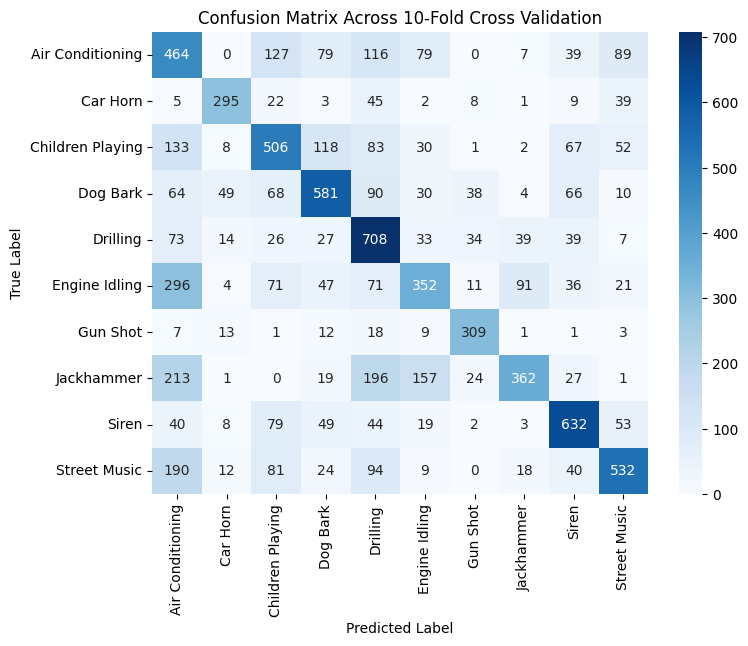

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.31      0.46      0.37      1000
        Car Horn       0.73      0.69      0.71       429
Children Playing       0.52      0.51      0.51      1000
        Dog Bark       0.61      0.58      0.59      1000
        Drilling       0.48      0.71      0.57      1000
   Engine Idling       0.49      0.35      0.41      1000
        Gun Shot       0.72      0.83      0.77       374
      Jackhammer       0.69      0.36      0.47      1000
           Siren       0.66      0.68      0.67       929
    Street Music       0.66      0.53      0.59      1000

        accuracy                           0.54      8732
       macro avg       0.59      0.57      0.57      8732
    weighted avg       0.57      0.54      0.54      8732



In [7]:
class_names = ['Air Conditioning', 'Car Horn', 'Children Playing', 'Dog Bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_log_mel).batch(64).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_log_mel).batch(64).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model(
    input_shape=(250, 64, 1),
    dropout_rates=[0.25, 0.25, 0.25],
    dense_units=128,
    learning_rate=0.00001,
    activation='relu',
    use_batch_norm=True)

    # Train model
    model.fit(train_ds, epochs=150)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...


2025-04-09 09:19:16.561172: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-04-09 09:19:16.561197: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-09 09:19:16.561200: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-04-09 09:19:16.561217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-09 09:19:16.561230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/200


2025-04-09 09:19:17.371900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.1059 - loss: 4.5488
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.1453 - loss: 4.1469
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.1586 - loss: 4.1360
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.1600 - loss: 4.4607
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.1865 - loss: 4.2851
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.1840 - loss: 4.4726
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1829 - loss: 4.3599
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2080 - loss: 4.2979
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2114 - loss: 4.3452
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1983 - loss: 4.4507
Epoch 11/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.2379 - loss: 4.2460
Epoch 12/200
123/123 ━━━━━━━━━━━━━━━━━━━━

2025-04-09 09:51:25.226032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.1193 - loss: 4.7309
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.1586 - loss: 4.4177
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.1796 - loss: 4.4850
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.1937 - loss: 4.3657
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2055 - loss: 4.5348
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.2150 - loss: 4.5059
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2127 - loss: 4.5343
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.2227 - loss: 4.5146
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2481 - loss: 4.4234
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2497 - loss: 4.3378
Epoch 11/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2396 - loss: 4.4286
Epoch 12/200
123/123 ━━━━━━━━

2025-04-09 10:22:22.873238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.1266 - loss: 4.6157
Epoch 2/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.1760 - loss: 4.1644
Epoch 3/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.1946 - loss: 4.2660
Epoch 4/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.1968 - loss: 4.2853
Epoch 5/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.2175 - loss: 4.3662
Epoch 6/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.2288 - loss: 4.3529
Epoch 7/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.2247 - loss: 4.3492
Epoch 8/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.2342 - loss: 4.3782
Epoch 9/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2394 - loss: 4.4022
Epoch 10/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2604 - loss: 4.2994
Epoch 11/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.2616 - loss: 4.3702
Epoch 12/200
122/122 ━━━━━━━━

2025-04-09 10:53:10.396797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.1205 - loss: 4.6096
Epoch 2/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1550 - loss: 4.2927
Epoch 3/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1765 - loss: 4.3360
Epoch 4/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.1869 - loss: 4.3651
Epoch 5/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1988 - loss: 4.3095
Epoch 6/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2040 - loss: 4.3950
Epoch 7/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.2162 - loss: 4.3311
Epoch 8/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.2167 - loss: 4.3812
Epoch 9/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2221 - loss: 4.4751
Epoch 10/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2305 - loss: 4.3140
Epoch 11/200
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2442 - loss: 4.4161
Epoch 12/200
121/121 ━━━━━━━━

2025-04-09 11:21:46.188083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.1402 - loss: 4.5987
Epoch 2/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.1658 - loss: 4.2584
Epoch 3/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1671 - loss: 4.4593
Epoch 4/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1890 - loss: 4.3678
Epoch 5/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.1880 - loss: 4.5072
Epoch 6/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.1894 - loss: 4.5632
Epoch 7/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2082 - loss: 4.5749
Epoch 8/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2136 - loss: 4.5799
Epoch 9/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2220 - loss: 4.4387
Epoch 10/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2232 - loss: 4.4116
Epoch 11/200
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2203 - loss: 4.5446
Epoch 12/200
122/122 ━━━━━━━━

2025-04-09 11:50:45.994472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.1356 - loss: 4.6966
Epoch 2/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1751 - loss: 4.3858
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1748 - loss: 4.4845
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1959 - loss: 4.4775
Epoch 5/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2098 - loss: 4.4636
Epoch 6/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2135 - loss: 4.4541
Epoch 7/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2222 - loss: 4.4569
Epoch 8/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2339 - loss: 4.3269
Epoch 9/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2428 - loss: 4.4362
Epoch 10/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2383 - loss: 4.4230
Epoch 11/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.2510 - loss: 4.4487
Epoch 12/200
124/124 ━━━━━━━━

2025-04-09 12:19:29.957682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.1283 - loss: 4.5546
Epoch 2/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.1664 - loss: 4.0885
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.1578 - loss: 4.2467
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.1728 - loss: 4.2989
Epoch 5/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.1775 - loss: 4.4157
Epoch 6/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.1857 - loss: 4.3239
Epoch 7/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.1907 - loss: 4.3817
Epoch 8/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.1946 - loss: 4.3174
Epoch 9/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.1943 - loss: 4.5387
Epoch 10/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.2050 - loss: 4.4857
Epoch 11/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.2038 - loss: 4.5576
Epoch 12/200
124/124 ━━━━━━━━

2025-04-09 12:47:48.700295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.1273 - loss: 4.3032
Epoch 2/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.1577 - loss: 4.1264
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.1774 - loss: 4.1618
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.1800 - loss: 4.2183
Epoch 5/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.1873 - loss: 4.2873
Epoch 6/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.1976 - loss: 4.3683
Epoch 7/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.2017 - loss: 4.3852
Epoch 8/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.2047 - loss: 4.4593
Epoch 9/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.2070 - loss: 4.3643
Epoch 10/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.2103 - loss: 4.4767
Epoch 11/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.2212 - loss: 4.3777
Epoch 12/200
124/124 ━━━━━━━━

2025-04-09 13:16:35.010067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.1121 - loss: 4.4953
Epoch 2/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.1567 - loss: 4.0872
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1708 - loss: 4.1768
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.1776 - loss: 4.3153
Epoch 5/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1882 - loss: 4.2892
Epoch 6/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.1974 - loss: 4.3510
Epoch 7/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2075 - loss: 4.2191
Epoch 8/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2189 - loss: 4.1622
Epoch 9/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2201 - loss: 4.3115
Epoch 10/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2270 - loss: 4.2113
Epoch 11/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.2378 - loss: 4.0715
Epoch 12/200
124/124 ━━━━━━━━

2025-04-09 13:45:41.257645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.1152 - loss: 5.0937
Epoch 2/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.1555 - loss: 4.5117
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1790 - loss: 4.4887
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.1863 - loss: 4.5116
Epoch 5/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.2054 - loss: 4.5531
Epoch 6/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2136 - loss: 4.4948
Epoch 7/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2183 - loss: 4.5077
Epoch 8/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2233 - loss: 4.5713
Epoch 9/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2259 - loss: 4.6029
Epoch 10/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.2427 - loss: 4.5401
Epoch 11/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.2362 - loss: 4.7620
Epoch 12/200
124/124 ━━━━━━━━

2025-04-09 14:15:04.712929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


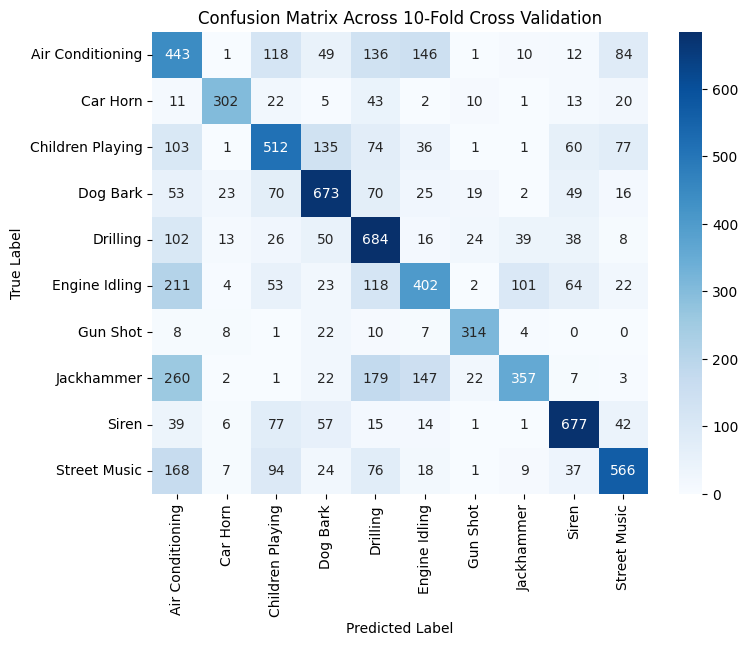

Classification Report:
                  precision    recall  f1-score   support

Air Conditioning       0.32      0.44      0.37      1000
        Car Horn       0.82      0.70      0.76       429
Children Playing       0.53      0.51      0.52      1000
        Dog Bark       0.63      0.67      0.65      1000
        Drilling       0.49      0.68      0.57      1000
   Engine Idling       0.49      0.40      0.44      1000
        Gun Shot       0.79      0.84      0.82       374
      Jackhammer       0.68      0.36      0.47      1000
           Siren       0.71      0.73      0.72       929
    Street Music       0.68      0.57      0.62      1000

        accuracy                           0.56      8732
       macro avg       0.61      0.59      0.59      8732
    weighted avg       0.59      0.56      0.57      8732



In [10]:
class_names = ['Air Conditioning', 'Car Horn', 'Children Playing', 'Dog Bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_log_mel).batch(64).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_log_mel).batch(64).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model(
    input_shape=(250, 64, 1),
    dropout_rates=[0.25, 0.25, 0.25],
    dense_units=128,
    learning_rate=0.00001,
    activation='relu',
    use_batch_norm=True)

    # Train model
    model.fit(train_ds, epochs=200)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

In [1]:
class_names = ['Air Conditioning', 'Car Horn', 'Children Playing', 'Dog Bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

# Store cumulative results across all folds
y_true_all = []
y_pred_all = []

for fold in range(1, 11):  # UrbanSound8K folds are from 1 to 10
    print(f"Training on Fold {fold} as validation set...")

    # Create datasets
    train_ds, test_ds = create_dataset(df, fold)

    # Preprocess datasets (load audio files)  
    train_ds = train_ds.map(preprocess_log_mel).batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.map(preprocess_log_mel).batch(32).prefetch(tf.data.AUTOTUNE)

    # Define model
    model = create_cnn_model(
    input_shape=(250, 64, 1),
    dropout_rates=[0.25, 0.25, 0.25],
    dense_units=128,
    learning_rate=0.00001,
    activation='relu',
    use_batch_norm=True)

    # Train model
    model.fit(train_ds, epochs=300)

    # Collect predictions and true labels
    for batch in test_ds:
        X_batch, y_batch = batch
        preds = model.predict(X_batch)
        y_true_all.extend(y_batch.numpy())  # Store true labels
        y_pred_all.extend(np.argmax(preds, axis=1))  # Convert softmax output to class indices

# Compute confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix Across 10-Fold Cross Validation")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names))

Training on Fold 1 as validation set...


NameError: name 'create_dataset' is not defined